# PostgreSQL B-tree Index Performance Analysis
## Multi-Dataset Comparative Analysis

This notebook analyzes the performance tradeoffs between no indexing vs single-column B-tree indexing across different OLTP read/write workloads.

**Analysis Modes:**
- **Multi-Dataset** (default): Analyze both memory-resident (1M rows) and disk-resident (16M rows) datasets
- **Single-Dataset**: Configure to analyze only one dataset regime

**Experimental Setup:**
- **Memory-Resident**: 1M rows (~0.25× RAM, cache-friendly)
- **Disk-Resident**: 16M rows (~2× RAM, IO-bound)
- PostgreSQL 15 with 4 CPUs, 8GB RAM
- Indexing: No index vs B-tree on `indexed_col`
- Read/Write Ratios: 90/10, 50/50, 10/90
- Concurrency Levels: 1, 8, 16, 32 clients
- 3 rounds for statistical confidence

**Configuration:** Modify `ANALYSIS_CONFIG` in Section 0 to control which datasets are analyzed.

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configure plot defaults
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Create directory structure for outputs
BASE_OUTPUT_DIR = Path('analysis_outputs')
PLOTS_DIR = BASE_OUTPUT_DIR / 'plots'
PLOTS_RESOLUTION = 96  # DPI for exported plots

# Create base directories
BASE_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# Will create dataset-specific and comparison subdirectories as needed
print(f"Output directory structure:")
print(f"  Base: {BASE_OUTPUT_DIR.absolute()}")
print(f"  Plots: {PLOTS_DIR.absolute()}")
print(f"\n✓ Subdirectories will be created per dataset during analysis")

Output directory structure:
  Base: /home/lemasc/projects/nao-docker/db_readwrite/analysis_outputs
  Plots: /home/lemasc/projects/nao-docker/db_readwrite/analysis_outputs/plots

✓ Subdirectories will be created per dataset during analysis


In [203]:
# Analysis Configuration
# Modify these settings to control which datasets are analyzed
ANALYSIS_CONFIG = {
    'datasets': ['disk-resident', 'memory-resident'],  # Default: analyze both regimes
    'enable_comparison': True,  # Generate comparative analysis plots
    'rounds': [1, 2, 3],  # Which rounds to include
    'base_path': 'results'  # Base directory for results
}

print("Analysis Configuration:")
print("="*60)
for key, value in ANALYSIS_CONFIG.items():
    print(f"  {key}: {value}")
print("="*60)
print(f"\n✓ Will analyze {len(ANALYSIS_CONFIG['datasets'])} dataset(s)")
if ANALYSIS_CONFIG['enable_comparison'] and len(ANALYSIS_CONFIG['datasets']) > 1:
    print(f"✓ Comparative analysis enabled")

Analysis Configuration:
  datasets: ['disk-resident', 'memory-resident']
  enable_comparison: True
  rounds: [1, 2, 3]
  base_path: results

✓ Will analyze 2 dataset(s)
✓ Comparative analysis enabled


## 0. Analysis Configuration

Configure which datasets to analyze and comparison settings.

In [204]:
def load_all_results(base_path='results/disk-resident', dataset_label='disk-resident'):
    """
    Load all JSON results from 3 rounds.
    Returns a structured DataFrame with configuration and metrics.
    
    Args:
        base_path: Path to the dataset results directory
        dataset_label: Label for this dataset (e.g., 'disk-resident', 'memory-resident')
    """
    all_data = []
    
    for round_num in [1, 2, 3]:
        round_path = Path(base_path) / str(round_num) / 'results'
        
        if not round_path.exists():
            print(f"⚠️  Warning: {round_path} does not exist, skipping...")
            continue
            
        json_files = list(round_path.glob('*.json'))
        
        # Filter out copy files
        json_files = [f for f in json_files if 'copy' not in f.name]
        
        for json_file in json_files:
            with open(json_file, 'r') as f:
                data = json.load(f)
            
            # Extract configuration
            config = data['config']
            read_ratio, write_ratio = config['read_write_ratio']
            
            # Create base record
            base_record = {
                'dataset': dataset_label,  # Add dataset label
                'round': round_num,
                'indexed': config['indexed'],
                'index_label': 'Indexed' if config['indexed'] else 'No Index',
                'read_ratio': read_ratio,
                'write_ratio': write_ratio,
                'ratio_label': f"{read_ratio}/{write_ratio}",
                'concurrency': config['concurrency'],
                'duration_seconds': data['duration_seconds'],
                'total_operations': data['total_operations'],
                'total_ops_per_sec': data['operations_per_second'],
                "file_name": f.name,
            }
            
            # Extract per-operation metrics
            for op_type, metrics in data['summary'].items():
                record = base_record.copy()
                record.update({
                    'operation': op_type,
                    'count': metrics['count'],
                    'success': metrics['success'],
                    'error': metrics['error'],
                    'min_latency_ms': metrics['min_latency_ms'],
                    'max_latency_ms': metrics['max_latency_ms'],
                    'mean_latency_ms': metrics['mean_latency_ms'],
                    'p50_latency_ms': metrics['p50_latency_ms'],
                    'p95_latency_ms': metrics['p95_latency_ms'],
                    'p99_latency_ms': metrics['p99_latency_ms'],
                    'ops_per_sec': metrics['ops_per_sec'],
                    'timeout_statement': metrics['errors_by_type']['timeout_statement'],
                    'timeout_lock': metrics['errors_by_type']['timeout_lock'],
                    'deadlock': metrics['errors_by_type']['deadlock'],
                    'error_other': metrics['errors_by_type']['other']
                })
                all_data.append(record)
    
    df = pd.DataFrame(all_data)
    
    if len(df) == 0:
        print(f"⚠️  Warning: No data loaded for {dataset_label}")
        return df
    
    # Add operation categories
    df['op_category'] = df['operation'].apply(
        lambda x: 'read' if x in ['point_lookup', 'range_scan', 'range_order'] else 'write'
    )
    
    return df


def load_multiple_datasets(config):
    """
    Load data from multiple datasets based on configuration.
    
    Args:
        config: ANALYSIS_CONFIG dictionary
        
    Returns:
        Combined DataFrame with all datasets
    """
    all_dfs = []
    
    print("Loading datasets...")
    print("="*60)
    
    for dataset_name in config['datasets']:
        dataset_path = Path(config['base_path']) / dataset_name
        print(f"\nLoading {dataset_name}...")
        
        df = load_all_results(
            base_path=str(dataset_path),
            dataset_label=dataset_name
        )
        
        if len(df) > 0:
            all_dfs.append(df)
            print(f"  ✓ Loaded {len(df)} records from {dataset_name}")
        else:
            print(f"  ✗ No data found for {dataset_name}")
    
    if len(all_dfs) == 0:
        print("\n❌ No data loaded from any dataset!")
        return pd.DataFrame()
    
    # Combine all datasets
    combined_df = pd.concat(all_dfs, ignore_index=True)
    
    print("\n" + "="*60)
    print(f"✓ Total records loaded: {len(combined_df)}")
    print(f"✓ Datasets: {sorted(combined_df['dataset'].unique())}")
    print(f"✓ Rounds: {sorted(combined_df['round'].unique())}")
    print(f"✓ Operations: {sorted(combined_df['operation'].unique())}")
    print(f"✓ Concurrency: {sorted(combined_df['concurrency'].unique())}")
    
    # Show breakdown by dataset
    print("\nRecords per dataset:")
    for dataset in combined_df['dataset'].unique():
        count = len(combined_df[combined_df['dataset'] == dataset])
        configs = len(combined_df[combined_df['dataset'] == dataset].groupby(
            ['indexed', 'ratio_label', 'concurrency', 'operation']
        ))
        print(f"  {dataset}: {count} records ({configs} unique configurations)")
    
    print("="*60)
    
    return combined_df


# Load all data using configuration
df = load_multiple_datasets(ANALYSIS_CONFIG)

if len(df) > 0:
    print(f"\n📊 Data loaded successfully!")
    print(f"\nFirst few records:")
    display(df.head())
else:
    print("\n❌ Failed to load data. Check paths and configuration.")

Loading datasets...

Loading disk-resident...
  ✓ Loaded 354 records from disk-resident

Loading memory-resident...
  ✓ Loaded 360 records from memory-resident

✓ Total records loaded: 714
✓ Datasets: ['disk-resident', 'memory-resident']
✓ Rounds: [np.int64(1), np.int64(2), np.int64(3)]
✓ Operations: ['insert', 'point_lookup', 'range_order', 'range_scan', 'update']
✓ Concurrency: [np.int64(1), np.int64(8), np.int64(16), np.int64(32)]

Records per dataset:
  disk-resident: 354 records (119 unique configurations)
  memory-resident: 360 records (120 unique configurations)

📊 Data loaded successfully!

First few records:


,dataset,round,indexed,index_label,read_ratio,write_ratio,ratio_label,concurrency,duration_seconds,total_operations,...,mean_latency_ms,p50_latency_ms,p95_latency_ms,p99_latency_ms,ops_per_sec,timeout_statement,timeout_lock,deadlock,error_other,op_category
0,disk-resident,1,True,Indexed,50,50,50/50,32,300.207747,124374,...,2.530827,1.210762,7.776112,11.119863,103.844755,0,0,0,0,read
1,disk-resident,1,True,Indexed,50,50,50/50,32,300.207747,124374,...,31.839986,32.273880,44.330894,50.308167,103.544963,0,0,0,0,write
2,disk-resident,1,True,Indexed,50,50,50/50,32,300.207747,124374,...,29.613781,29.627316,42.627271,47.684549,103.148571,0,0,0,0,write
3,disk-resident,1,True,Indexed,50,50,50/50,32,300.207747,124374,...,244.687085,254.160848,289.716397,302.751641,41.511254,0,0,0,0,read
4,disk-resident,1,True,Indexed,50,50,50/50,32,300.207747,124374,...,244.224433,253.985672,289.434697,303.260765,62.243564,0,0,0,0,read


In [205]:
df[(df['dataset'] == "disk-resident")].groupby(["index_label", "ratio_label"]).count()

dataset  round  indexed  read_ratio  write_ratio  \
index_label ratio_label                                                     
Indexed     10/90             60     60       60          60           60   
            50/50             60     60       60          60           60   
            90/10             60     60       60          60           60   
No Index    10/90             59     59       59          59           59   
            50/50             60     60       60          60           60   
            90/10             55     55       55          55           55   

                         concurrency  duration_seconds  total_operations  \
index_label ratio_label                                                    
Indexed     10/90                 60                60                60   
            50/50                 60                60                60   
            90/10                 60                60                60   
No Index    10/90                 59                59                59   
            50/50                 60                60                60   
            90/10                 55                55                55   

                         total_ops_per_sec  file_name  ...  mean_latency_ms  \
index_label ratio_label                                ...                    
Indexed     10/90                       60         60  ...               60   
            50/50                       60         60  ...               60   
            90/10                       60         60  ...               60   
No Index    10/90                       59         59  ...               59   
            50/50                       60         60  ...               60   
            90/10                       55         55  ...               55   

                         p50_latency_ms  p95_latency_ms  p99_latency_ms  \
index_label ratio_label                                                   
Indexed     10/90                    60              60              60   
            50/50                    60              60              60   
            90/10                    60              60              60   
No Index    10/90                    59              59              59   
            50/50                    60              60              60   
            90/10                    55              55              55   

                         ops_per_sec  timeout_statement  timeout_lock  \
index_label ratio_label                                                 
Indexed     10/90                 60                 60            60   
            50/50                 60                 60            60   
            90/10                 60                 60            60   
No Index    10/90                 59                 59            59   
            50/50                 60                 60            60   
            90/10                 55                 55            55   

                         deadlock  error_other  op_category  
index_label ratio_label                                      
Indexed     10/90              60           60           60  
            50/50              60           60           60  
            90/10              60           60           60  
No Index    10/90              59           59           59  
            50/50              60           60           60  
            90/10              55           55           55  

[6 rows x 26 columns]

In [206]:
df.groupby(["dataset", "round", "index_label", "ratio_label", "op_category"]).count()

indexed  \
dataset         round index_label ratio_label op_category            
disk-resident   1     Indexed     10/90       read              12   
                                              write              8   
                                  50/50       read              12   
                                              write              8   
                                  90/10       read              12   
...                                                            ...   
memory-resident 3     No Index    10/90       write              8   
                                  50/50       read              12   
                                              write              8   
                                  90/10       read              12   
                                              write              8   

                                                           read_ratio  \
dataset         round index_label ratio_label op_category               
disk-resident   1     Indexed     10/90       read                 12   
                                              write                 8   
                                  50/50       read                 12   
                                              write                 8   
                                  90/10       read                 12   
...                                                               ...   
memory-resident 3     No Index    10/90       write                 8   
                                  50/50       read                 12   
                                              write                 8   
                                  90/10       read                 12   
                                              write                 8   

                                                           write_ratio  \
dataset         round index_label ratio_label op_category                
disk-resident   1     Indexed     10/90       read                  12   
                                              write                  8   
                                  50/50       read                  12   
                                              write                  8   
                                  90/10       read                  12   
...                                                                ...   
memory-resident 3     No Index    10/90       write                  8   
                                  50/50       read                  12   
                                              write                  8   
                                  90/10       read                  12   
                                              write                  8   

                                                           concurrency  \
dataset         round index_label ratio_label op_category                
disk-resident   1     Indexed     10/90       read                  12   
                                              write                  8   
                                  50/50       read                  12   
                                              write                  8   
                                  90/10       read                  12   
...                                                                ...   
memory-resident 3     No Index    10/90       write                  8   
                                  50/50       read                  12   
                                              write                  8   
                                  90/10       read                  12   
                                              write                  8   

                                                           duration_seconds  \
dataset         round index_label ratio_label op_category                     
disk-resident   1     Indexed     10/90       read                       12   
                                   

In [207]:
df.groupby(["dataset", "round", "index_label", "ratio_label", "op_category"]).count()

indexed  \
dataset         round index_label ratio_label op_category            
disk-resident   1     Indexed     10/90       read              12   
                                              write              8   
                                  50/50       read              12   
                                              write              8   
                                  90/10       read              12   
...                                                            ...   
memory-resident 3     No Index    10/90       write              8   
                                  50/50       read              12   
                                              write              8   
                                  90/10       read              12   
                                              write              8   

                                                           read_ratio  \
dataset         round index_label ratio_label op_category               
disk-resident   1     Indexed     10/90       read                 12   
                                              write                 8   
                                  50/50       read                 12   
                                              write                 8   
                                  90/10       read                 12   
...                                                               ...   
memory-resident 3     No Index    10/90       write                 8   
                                  50/50       read                 12   
                                              write                 8   
                                  90/10       read                 12   
                                              write                 8   

                                                           write_ratio  \
dataset         round index_label ratio_label op_category                
disk-resident   1     Indexed     10/90       read                  12   
                                              write                  8   
                                  50/50       read                  12   
                                              write                  8   
                                  90/10       read                  12   
...                                                                ...   
memory-resident 3     No Index    10/90       write                  8   
                                  50/50       read                  12   
                                              write                  8   
                                  90/10       read                  12   
                                              write                  8   

                                                           concurrency  \
dataset         round index_label ratio_label op_category                
disk-resident   1     Indexed     10/90       read                  12   
                                              write                  8   
                                  50/50       read                  12   
                                              write                  8   
                                  90/10       read                  12   
...                                                                ...   
memory-resident 3     No Index    10/90       write                  8   
                                  50/50       read                  12   
                                              write                  8   
                                  90/10       read                  12   
                                              write                  8   

                                                           duration_seconds  \
dataset         round index_label ratio_label op_category                     
disk-resident   1     Indexed     10/90       read                       12   
                                   

In [208]:
read_counts = df[df["op_category"] == "read"].groupby(["dataset", "round", "index_label", "ratio_label", "op_category"]).transform("size")

df[(df["op_category"] == "read") & (read_counts < 12)].groupby(["dataset", "round", "ratio_label", "concurrency", "file_name"]).count()

indexed  \
dataset       round ratio_label concurrency file_name                                                     
disk-resident 1     10/90       1           results/disk-resident/1/results/no_index_r10w90...        2   
                                8           results/disk-resident/1/results/no_index_r10w90...        3   
                                16          results/disk-resident/1/results/no_index_r10w90...        3   
                                32          results/disk-resident/1/results/no_index_r10w90...        3   
              2     90/10       1           results/disk-resident/2/results/no_index_r90w10...        2   
                                8           results/disk-resident/2/results/no_index_r90w10...        3   
                                16          results/disk-resident/2/results/no_index_r90w10...        3   
                                32          results/disk-resident/2/results/no_index_r90w10...        3   

                                                                                                index_label  \
dataset       round ratio_label concurrency file_name                                                         
disk-resident 1     10/90       1           results/disk-resident/1/results/no_index_r10w90...            2   
                                8           results/disk-resident/1/results/no_index_r10w90...            3   
                                16          results/disk-resident/1/results/no_index_r10w90...            3   
                                32          results/disk-resident/1/results/no_index_r10w90...            3   
              2     90/10       1           results/disk-resident/2/results/no_index_r90w10...            2   
                                8           results/disk-resident/2/results/no_index_r90w10...            3   
                                16          results/disk-resident/2/results/no_index_r90w10...            3   
                                32          results/disk-resident/2/results/no_index_r90w10...            3   

                                                                                                read_ratio  \
dataset       round ratio_label concurrency file_name                                                        
disk-resident 1     10/90       1           results/disk-resident/1/results/no_index_r10w90...           2   
                                8           results/disk-resident/1/results/no_index_r10w90...           3   
                                16          results/disk-resident/1/results/no_index_r10w90...           3   
                                32          results/disk-resident/1/results/no_index_r10w90...           3   
              2     90/10       1           results/disk-resident/2/results/no_index_r90w10...           2   
                                8           results/disk-resident/2/results/no_index_r90w10...           3   
                                16          results/disk-resident/2/results/no_index_r90w10...           3   
                                32          results/disk-resident/2/results/no_index_r90w10...           3   

                                                                                                write_ratio  \
dataset       round ratio_label concurrency file_name                                                         
disk-resident 1     10/90       1           results/disk-resident/1/results/no_index_r10w90...            2   
                                8           results/disk-resident/1/results/no_index_r10w90...            3   
                                16          results/disk-resident/1/results/no_index_r10w90...            3   
                                32          results/disk-resident/1/results/no_index_r10w90...            3   
              2     90/10       1           results/disk-resident/2/results/no_index_r90w10...            2   
                                8   

In [209]:
write_counts = df[df["op_category"] == "write"].groupby(["dataset", "round", "index_label", "ratio_label", "op_category"]).transform("size")

df[(df["op_category"] == "write") & (read_counts < 8)].groupby(["dataset", "round", "file_name"]).count()

,,,indexed,index_label,read_ratio,write_ratio,ratio_label,concurrency,duration_seconds,total_operations,total_ops_per_sec,operation,...,mean_latency_ms,p50_latency_ms,p95_latency_ms,p99_latency_ms,ops_per_sec,timeout_statement,timeout_lock,deadlock,error_other,op_category
dataset,round,file_name,,,,,,,,,,,,,,,,,,,,,


In [210]:
df.groupby(["dataset", "round", "index_label", "ratio_label"]).count()

indexed  read_ratio  \
dataset         round index_label ratio_label                        
disk-resident   1     Indexed     10/90             20          20   
                                  50/50             20          20   
                                  90/10             20          20   
                      No Index    10/90             19          19   
                                  50/50             20          20   
                                  90/10             18          18   
                2     Indexed     10/90             20          20   
                                  50/50             20          20   
                                  90/10             20          20   
                      No Index    10/90             20          20   
                                  50/50             20          20   
                                  90/10             18          18   
                3     Indexed     10/90             20          20   
                                  50/50             20          20   
                                  90/10             20          20   
                      No Index    10/90             20          20   
                                  50/50             20          20   
                                  90/10             19          19   
memory-resident 1     Indexed     10/90             20          20   
                                  50/50             20          20   
                                  90/10             20          20   
                      No Index    10/90             20          20   
                                  50/50             20          20   
                                  90/10             20          20   
                2     Indexed     10/90             20          20   
                                  50/50             20          20   
                                  90/10             20          20   
                      No Index    10/90             20          20   
                                  50/50             20          20   
                                  90/10             20          20   
                3     Indexed     10/90             20          20   
                                  50/50             20          20   
                                  90/10             20          20   
                      No Index    10/90             20          20   
                                  50/50             20          20   
                                  90/10             20          20   

                                               write_ratio  concurrency  \
dataset         round index_label ratio_label                             
disk-resident   1     Indexed     10/90                 20           20   
                                  50/50                 20           20   
                                  90/10                 20           20   
                      No Index    10/90                 19           19   
                                  50/50                 20           20   
                                  90/10                 18           18   
                2     Indexed     10/90                 20           20   
                                  50/50                 20           20   
                                  90/10                 20           20   
                      No Index    10/90                 20           20   
                                  50/50                 20           20   
                                  90/10                 18           18   
                3     Indexed     10/90                 20           20   
                                  50/50                 20           20   
                                  90/10                 20           20   
                      No Index    10/90                 20           20   
                                  50

In [211]:
counts = df.groupby(["dataset", "round", "index_label", "ratio_label"]).transform('size')

df[counts < 20].groupby(["dataset", "round", "concurrency", "file_name"]).count()

indexed  \
dataset       round concurrency file_name                                                     
disk-resident 1     1           results/disk-resident/1/results/no_index_r10w90...        4   
                                results/disk-resident/1/results/no_index_r90w10...        3   
                    8           results/disk-resident/1/results/no_index_r10w90...        5   
                                results/disk-resident/1/results/no_index_r90w10...        5   
                    16          results/disk-resident/1/results/no_index_r10w90...        5   
                                results/disk-resident/1/results/no_index_r90w10...        5   
                    32          results/disk-resident/1/results/no_index_r10w90...        5   
                                results/disk-resident/1/results/no_index_r90w10...        5   
              2     1           results/disk-resident/2/results/no_index_r90w10...        3   
                    8           results/disk-resident/2/results/no_index_r90w10...        5   
                    16          results/disk-resident/2/results/no_index_r90w10...        5   
                    32          results/disk-resident/2/results/no_index_r90w10...        5   
              3     1           results/disk-resident/3/results/no_index_r90w10...        4   
                    8           results/disk-resident/3/results/no_index_r90w10...        5   
                    16          results/disk-resident/3/results/no_index_r90w10...        5   
                    32          results/disk-resident/3/results/no_index_r90w10...        5   

                                                                                    index_label  \
dataset       round concurrency file_name                                                         
disk-resident 1     1           results/disk-resident/1/results/no_index_r10w90...            4   
                                results/disk-resident/1/results/no_index_r90w10...            3   
                    8           results/disk-resident/1/results/no_index_r10w90...            5   
                                results/disk-resident/1/results/no_index_r90w10...            5   
                    16          results/disk-resident/1/results/no_index_r10w90...            5   
                                results/disk-resident/1/results/no_index_r90w10...            5   
                    32          results/disk-resident/1/results/no_index_r10w90...            5   
                                results/disk-resident/1/results/no_index_r90w10...            5   
              2     1           results/disk-resident/2/results/no_index_r90w10...            3   
                    8           results/disk-resident/2/results/no_index_r90w10...            5   
                    16          results/disk-resident/2/results/no_index_r90w10...            5   
                    32          results/disk-resident/2/results/no_index_r90w10...            5   
              3     1           results/disk-resident/3/results/no_index_r90w10...            4   
                    8           results/disk-resident/3/results/no_index_r90w10...            5   
                    16          results/disk-resident/3/results/no_index_r90w10...            5   
                    32          results/disk-resident/3/results/no_index_r90w10...            5   

                                                                                    read_ratio  \
dataset       round concurrency file_name                                                        
disk-resident 1     1           results/disk-resident/1/results/no_index_r10w90...           4   
                                results/disk-resident/1/results/no_index_r90w10...           3   
                    8           results/disk-resident/1/results/no_index_r10w90...           5   
                                results/disk-resident/1/results/no_index_r90w10...           5   
  

In [212]:
df[(df['dataset'] == "disk-resident") & (df["ratio_label"] == "90/10")].groupby(["round", ]).count()

,dataset,indexed,index_label,read_ratio,write_ratio,ratio_label,concurrency,duration_seconds,total_operations,total_ops_per_sec,...,mean_latency_ms,p50_latency_ms,p95_latency_ms,p99_latency_ms,ops_per_sec,timeout_statement,timeout_lock,deadlock,error_other,op_category
round,,,,,,,,,,,,,,,,,,,,,
1,38,38,38,38,38,38,38,38,38,38,...,38,38,38,38,38,38,38,38,38,38
2,38,38,38,38,38,38,38,38,38,38,...,38,38,38,38,38,38,38,38,38,38
3,39,39,39,39,39,39,39,39,39,39,...,39,39,39,39,39,39,39,39,39,39


In [213]:
df[df["dataset"] == "disk-resident"].groupby(["indexed", "read_ratio", "write_ratio", "concurrency"])["operation"].count()

indexed  read_ratio  write_ratio  concurrency
False    10          90           1              14
                                  8              15
                                  16             15
                                  32             15
         50          50           1              15
                                  8              15
                                  16             15
                                  32             15
         90          10           1              10
                                  8              15
                                  16             15
                                  32             15
True     10          90           1              15
                                  8              15
                                  16             15
                                  32             15
         50          50           1              15
                                  8              15
                  

In [214]:
# Compute aggregated statistics across rounds
def compute_statistics(df):
    """
    Aggregate metrics across 3 rounds with mean and 95% confidence intervals.
    """
    group_cols = ['dataset', 'indexed', 'index_label', 'read_ratio', 'write_ratio', 'ratio_label',
                  'concurrency', 'operation', 'op_category']

    # Define aggregation functions separately for compatibility
    def calc_ci_95(series):
        """Calculate 95% confidence interval using t-distribution"""
        n = len(series)
        if n > 1:
            std = series.std()
            return stats.t.ppf(0.975, n-1) * std / np.sqrt(n)
        return 0

    # Aggregate with standard functions
    agg_df = df.groupby(group_cols).agg({
        'p95_latency_ms': ['mean', 'std', 'min', 'max', calc_ci_95],
        'p50_latency_ms': ['mean', 'std', 'min', 'max', calc_ci_95],
        'mean_latency_ms': ['mean', 'std', 'min', 'max', calc_ci_95],
        'ops_per_sec': ['mean', 'std', 'min', 'max', calc_ci_95],
        'total_ops_per_sec': ['mean', 'std', 'min', 'max', calc_ci_95],
        'count': ['mean', 'std', 'min', 'max', calc_ci_95],
        'error': 'sum',
        'timeout_statement': 'sum',
        'timeout_lock': 'sum',
        'deadlock': 'sum'
    }).reset_index()

    # Flatten multi-level columns with proper naming
    new_columns = []
    for col in agg_df.columns:
        if isinstance(col, tuple):
            if col[1] == 'calc_ci_95':
                new_columns.append(f"{col[0]}_ci_95")
            elif col[1] in ['mean', 'std', 'min', 'max']:
                new_columns.append(f"{col[0]}_{col[1]}")
            else:
                new_columns.append('_'.join(str(c) for c in col).strip('_'))
        else:
            new_columns.append(col)

    agg_df.columns = new_columns

    return agg_df

stats_df = compute_statistics(df)
print(f"\nAggregated statistics: {len(stats_df)} configurations")
stats_df.head(10)


Aggregated statistics: 239 configurations


,dataset,indexed,index_label,read_ratio,write_ratio,ratio_label,concurrency,operation,op_category,p95_latency_ms_mean,...,total_ops_per_sec_ci_95,count_mean,count_std,count_min,count_max,count_ci_95,error_sum,timeout_statement_sum,timeout_lock_sum,deadlock_sum
0,disk-resident,False,No Index,10,90,10/90,1,insert,write,0.872003,...,0.390789,55.666667,22.007574,34,78,54.669846,0,0,0,0
1,disk-resident,False,No Index,10,90,10/90,1,point_lookup,read,44581.265323,...,0.390789,6.666667,2.081666,5,9,5.171145,16,16,0,0
2,disk-resident,False,No Index,10,90,10/90,1,range_order,read,30011.670740,...,1.121072,2.500000,2.121320,1,4,19.059307,5,5,0,0
3,disk-resident,False,No Index,10,90,10/90,1,range_scan,read,4.159997,...,0.390789,4.000000,2.000000,2,6,4.968275,0,0,0,0
4,disk-resident,False,No Index,10,90,10/90,1,update,write,1.536843,...,0.390789,55.000000,19.000000,39,76,47.198617,0,0,0,0
5,disk-resident,False,No Index,10,90,10/90,8,insert,write,1.449300,...,0.107348,474.333333,46.306947,440,527,115.032833,0,0,0,0
6,disk-resident,False,No Index,10,90,10/90,8,point_lookup,read,30013.056478,...,0.107348,54.666667,3.214550,51,57,7.985386,163,163,0,0
7,disk-resident,False,No Index,10,90,10/90,8,range_order,read,44827.285562,...,0.107348,23.666667,0.577350,23,24,1.434218,68,68,0,0
8,disk-resident,False,No Index,10,90,10/90,8,range_scan,read,14.500536,...,0.107348,33.666667,10.408330,22,42,25.855725,0,0,0,0
9,disk-resident,False,No Index,10,90,10/90,8,update,write,4.226290,...,0.107348,495.666667,22.368132,476,520,55.565520,0,0,0,0


In [215]:
# Check for errors and timeouts per dataset
print("="*80)
print("DATA QUALITY CHECK")
print("="*80)

for dataset_name in sorted(df['dataset'].unique()):
    print(f"\n{'='*80}")
    print(f"Dataset: {dataset_name.upper()}")
    print(f"{'='*80}")
    
    dataset_df = df[df['dataset'] == dataset_name]
    
    error_summary = dataset_df.groupby(['indexed', 'ratio_label', 'concurrency', 'operation']).agg({
        'error': 'sum',
        'timeout_statement': 'sum',
        'timeout_lock': 'sum',
        'deadlock': 'sum'
    }).reset_index()
    
    total_errors = error_summary['error'].sum()
    total_timeouts = error_summary['timeout_statement'].sum() + error_summary['timeout_lock'].sum()
    
    print(f"\nTotal errors across all runs: {total_errors}")
    print(f"Total timeouts: {total_timeouts}")
    print(f"  - Statement timeouts: {error_summary['timeout_statement'].sum()}")
    print(f"  - Lock timeouts: {error_summary['timeout_lock'].sum()}")
    print(f"  - Deadlocks: {error_summary['deadlock'].sum()}")
    
    if total_errors > 0 or total_timeouts > 0:
        print("\nConfigurations with errors/timeouts:")
        problematic = error_summary[
            (error_summary['error'] > 0) | 
            (error_summary['timeout_statement'] > 0) | 
            (error_summary['timeout_lock'] > 0)
        ]
        display(problematic)
    else:
        print("✓ No errors or timeouts detected - clean dataset!")

print("\n" + "="*80)

DATA QUALITY CHECK

Dataset: DISK-RESIDENT

Total errors across all runs: 3798
Total timeouts: 3798
  - Statement timeouts: 3798
  - Lock timeouts: 0
  - Deadlocks: 0

Configurations with errors/timeouts:


,indexed,ratio_label,concurrency,operation,error,timeout_statement,timeout_lock,deadlock
1,False,10/90,1,point_lookup,16,16,0,0
2,False,10/90,1,range_order,5,5,0,0
6,False,10/90,8,point_lookup,163,163,0,0
7,False,10/90,8,range_order,68,68,0,0
11,False,10/90,16,point_lookup,338,338,0,0
12,False,10/90,16,range_order,142,142,0,0
16,False,10/90,32,point_lookup,675,675,0,0
17,False,10/90,32,range_order,285,285,0,0
21,False,50/50,1,point_lookup,22,22,0,0
22,False,50/50,1,range_order,8,8,0,0



Dataset: MEMORY-RESIDENT

Total errors across all runs: 0
Total timeouts: 0
  - Statement timeouts: 0
  - Lock timeouts: 0
  - Deadlocks: 0
✓ No errors or timeouts detected - clean dataset!



## 3. P95 Latency Analysis

Primary decision-driving metric: **P95 latency** per operation type.

GENERATING P95 LATENCY PLOTS (ALL OPERATIONS)

Dataset: disk-resident


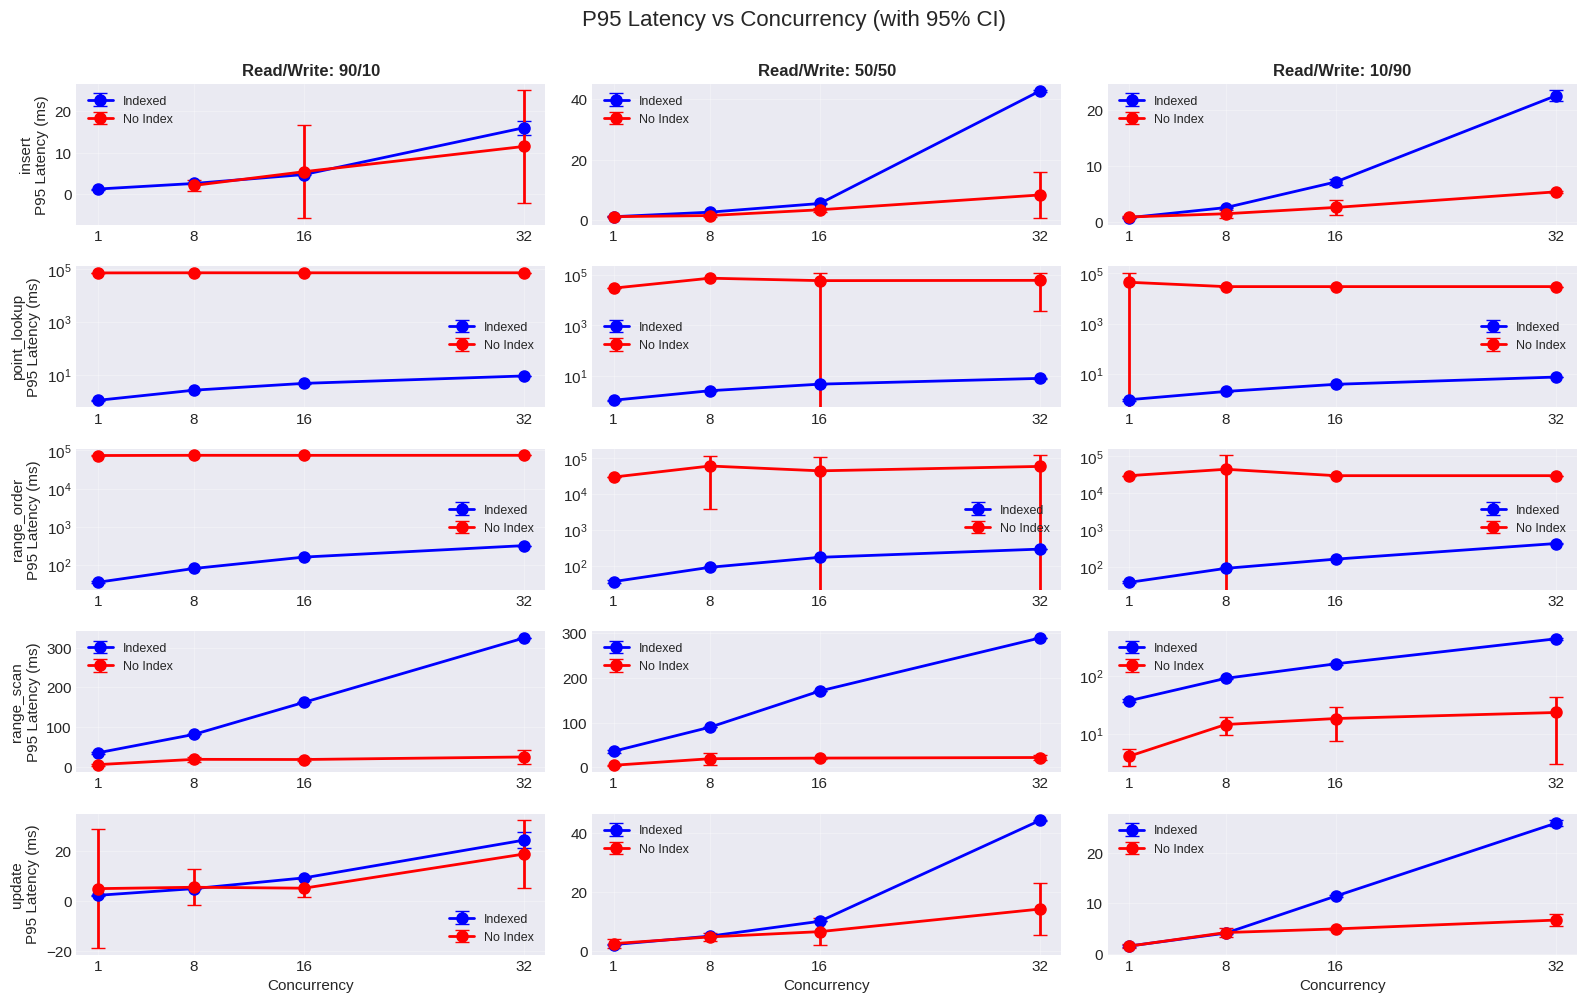

  ✓ Saved: analysis_outputs/plots/disk-resident/01_p95_latency_all_operations.png

Dataset: memory-resident


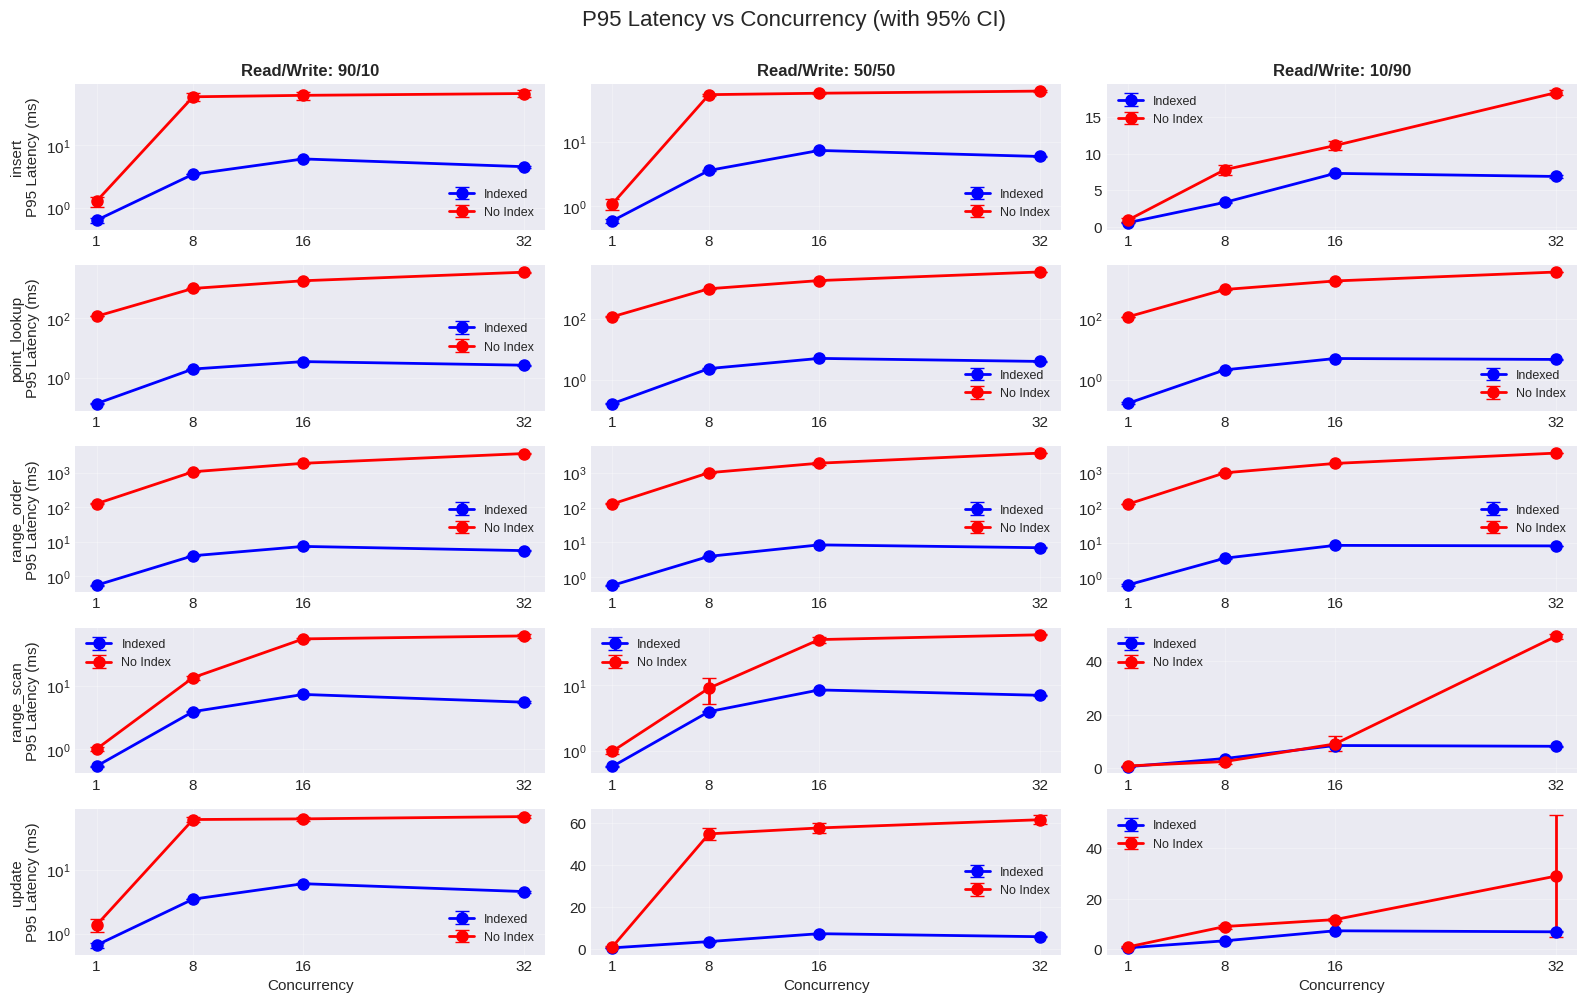

  ✓ Saved: analysis_outputs/plots/memory-resident/01_p95_latency_all_operations.png



In [216]:
def plot_p95_latency_by_ratio(stats_df, operation_filter=None, figsize=(16, 10)):
    """
    Plot P95 latency vs concurrency for each read/write ratio.
    Separate plots for each operation type.
    """
    df_plot = stats_df.copy()
    
    if operation_filter:
        df_plot = df_plot[df_plot['operation'].isin(operation_filter)]
    
    operations = sorted(df_plot['operation'].unique())
    ratios = sorted(df_plot['ratio_label'].unique(), key=lambda x: int(x.split('/')[0]), reverse=True)
    
    fig, axes = plt.subplots(len(operations), len(ratios), figsize=figsize, squeeze=False)
    fig.suptitle('P95 Latency vs Concurrency (with 95% CI)', fontsize=16, y=1.0)
    
    for op_idx, operation in enumerate(operations):
        for ratio_idx, ratio in enumerate(ratios):
            ax = axes[op_idx, ratio_idx]
            
            data = df_plot[(df_plot['operation'] == operation) & (df_plot['ratio_label'] == ratio)]
            
            for indexed in [True, False]:
                subset = data[data['indexed'] == indexed].sort_values('concurrency')
                
                if len(subset) > 0:
                    label = 'Indexed' if indexed else 'No Index'
                    color = 'blue' if indexed else 'red'
                    
                    ax.errorbar(
                        subset['concurrency'], 
                        subset['p95_latency_ms_mean'],
                        yerr=subset['p95_latency_ms_ci_95'],
                        marker='o', 
                        label=label,
                        color=color,
                        capsize=5,
                        linewidth=2,
                        markersize=8
                    )
            
            # Formatting
            if op_idx == 0:
                ax.set_title(f'Read/Write: {ratio}', fontsize=12, fontweight='bold')
            if ratio_idx == 0:
                ax.set_ylabel(f'{operation}\nP95 Latency (ms)', fontsize=11)
            if op_idx == len(operations) - 1:
                ax.set_xlabel('Concurrency', fontsize=11)
            
            ax.set_xticks([1, 8, 16, 32])
            ax.grid(True, alpha=0.3)
            ax.legend(loc='best', fontsize=9)
            
            # Use log scale for y-axis if range is large
            if len(data) > 0 and data['p95_latency_ms_mean'].max() / data['p95_latency_ms_mean'].min() > 100:
                ax.set_yscale('log')
    
    plt.tight_layout()
    return fig


# Generate plots for each dataset
print("="*80)
print("GENERATING P95 LATENCY PLOTS (ALL OPERATIONS)")
print("="*80)

for dataset_name in sorted(stats_df['dataset'].unique()):
    print(f"\nDataset: {dataset_name}")
    
    # Create dataset-specific directory
    dataset_plot_dir = PLOTS_DIR / dataset_name
    dataset_plot_dir.mkdir(parents=True, exist_ok=True)
    
    # Filter data for this dataset
    dataset_stats = stats_df[stats_df['dataset'] == dataset_name]
    
    # Plot all operations
    fig = plot_p95_latency_by_ratio(dataset_stats)
    display(fig)
    plot_path = dataset_plot_dir / '01_p95_latency_all_operations.png'
    fig.savefig(plot_path, dpi=PLOTS_RESOLUTION, bbox_inches='tight')
    print(f"  ✓ Saved: {plot_path}")
    plt.close(fig)

print("\n" + "="*80)

GENERATING P95 LATENCY PLOTS (READ OPERATIONS)

Dataset: disk-resident


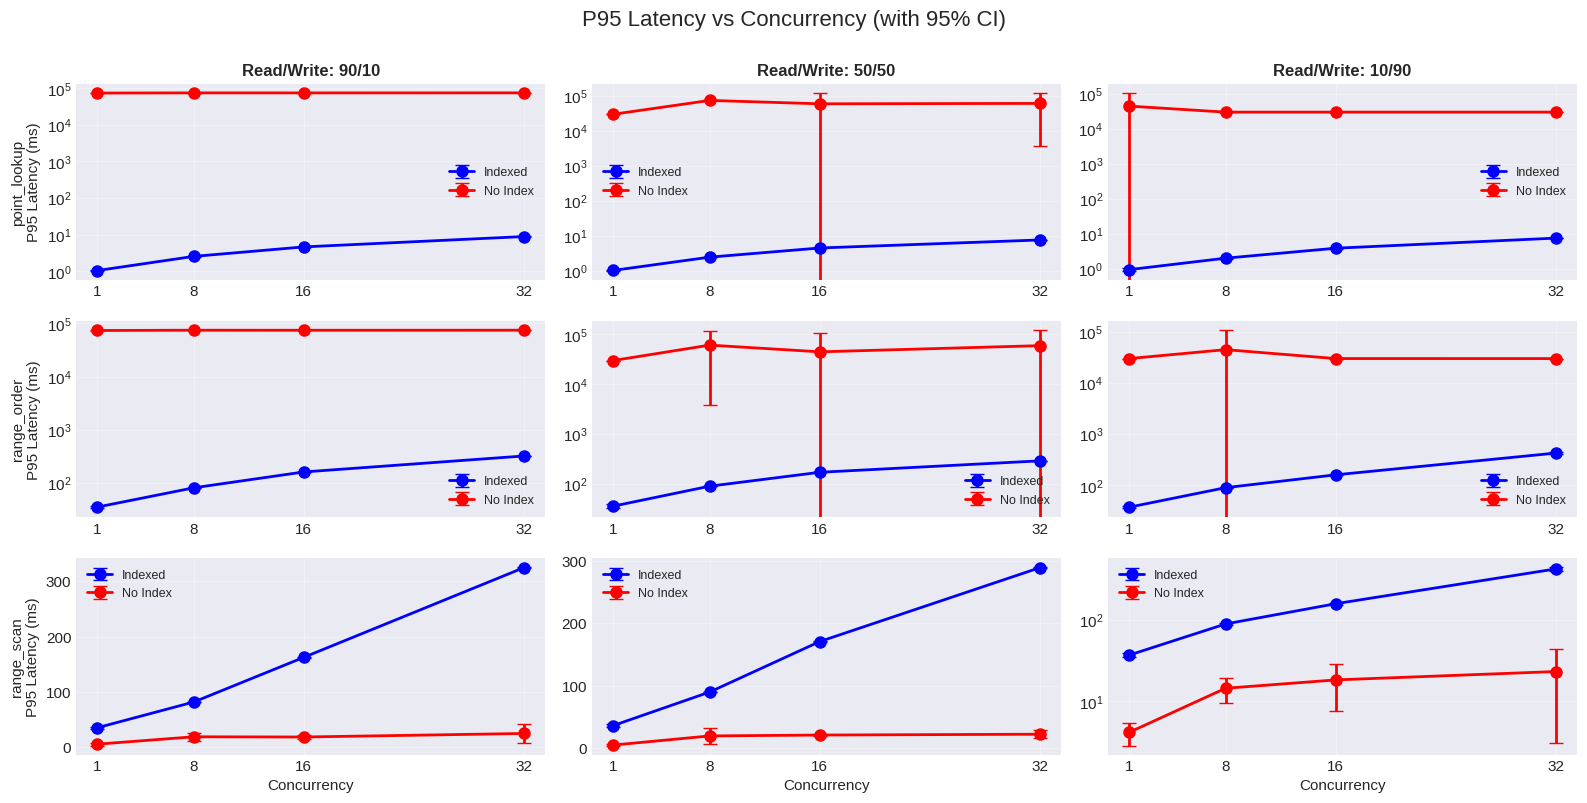

  ✓ Saved: analysis_outputs/plots/disk-resident/02_p95_latency_read_operations.png

Dataset: memory-resident


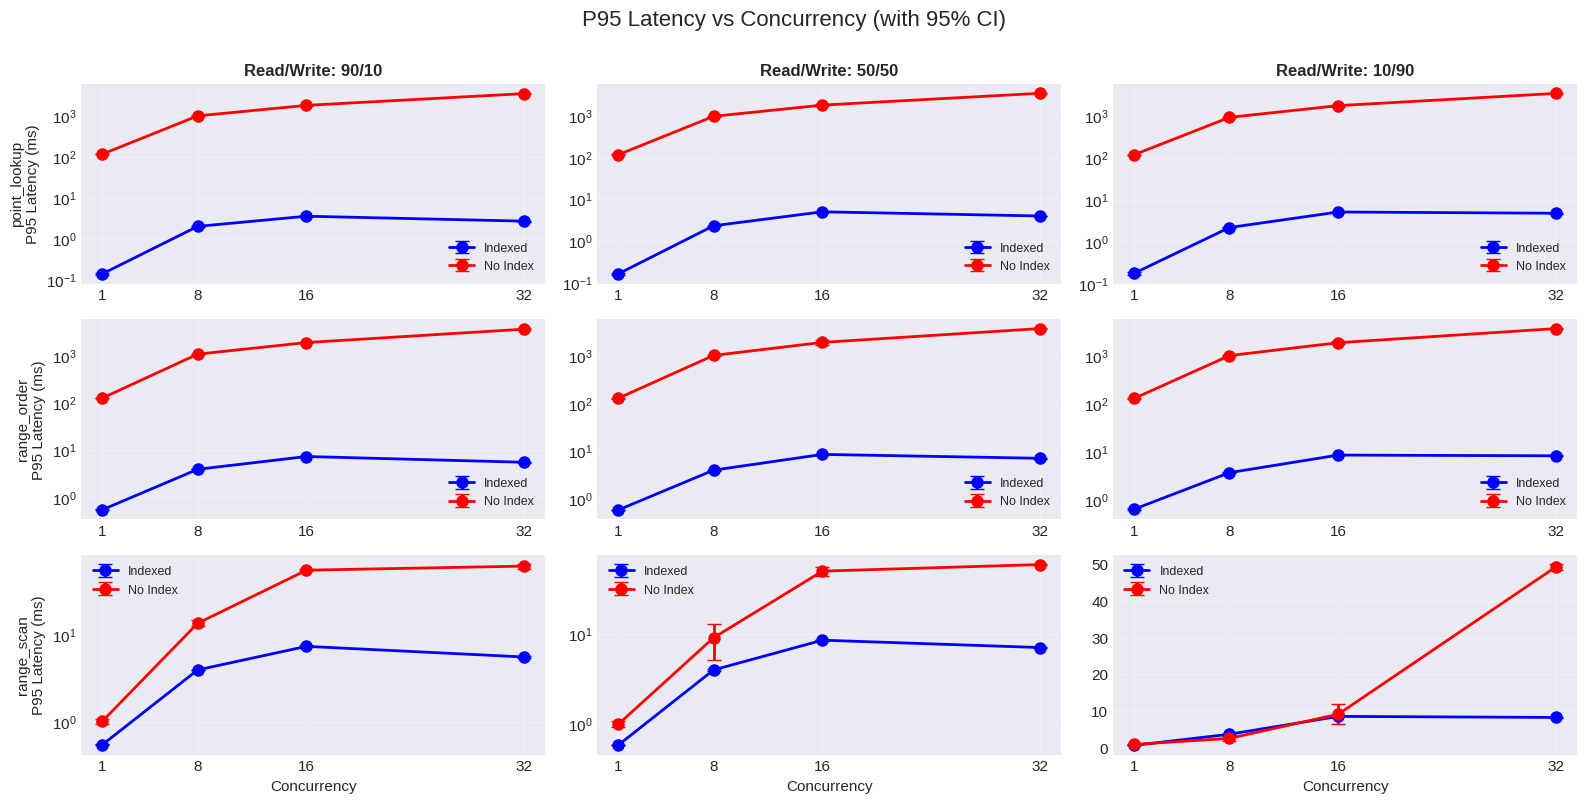

  ✓ Saved: analysis_outputs/plots/memory-resident/02_p95_latency_read_operations.png



In [217]:
# Focused view: Read operations only
print("="*80)
print("GENERATING P95 LATENCY PLOTS (READ OPERATIONS)")
print("="*80)

for dataset_name in sorted(stats_df['dataset'].unique()):
    print(f"\nDataset: {dataset_name}")
    
    dataset_plot_dir = PLOTS_DIR / dataset_name
    dataset_stats = stats_df[stats_df['dataset'] == dataset_name]
    
    fig = plot_p95_latency_by_ratio(
        dataset_stats, 
        operation_filter=['point_lookup', 'range_scan', 'range_order'],
        figsize=(16, 8)
    )
    display(fig)
    plot_path = dataset_plot_dir / '02_p95_latency_read_operations.png'
    fig.savefig(plot_path, dpi=PLOTS_RESOLUTION, bbox_inches='tight')
    print(f"  ✓ Saved: {plot_path}")
    plt.close(fig)

print("\n" + "="*80)

GENERATING P95 LATENCY PLOTS (WRITE OPERATIONS)

Dataset: disk-resident


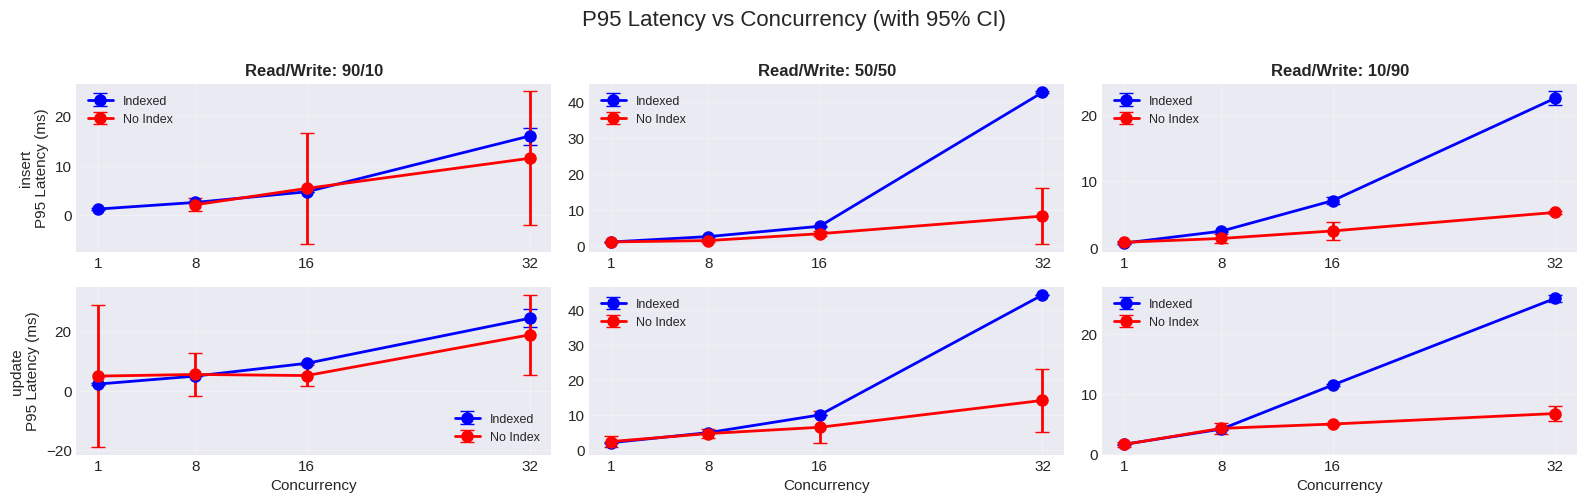

  ✓ Saved: analysis_outputs/plots/disk-resident/03_p95_latency_write_operations.png

Dataset: memory-resident


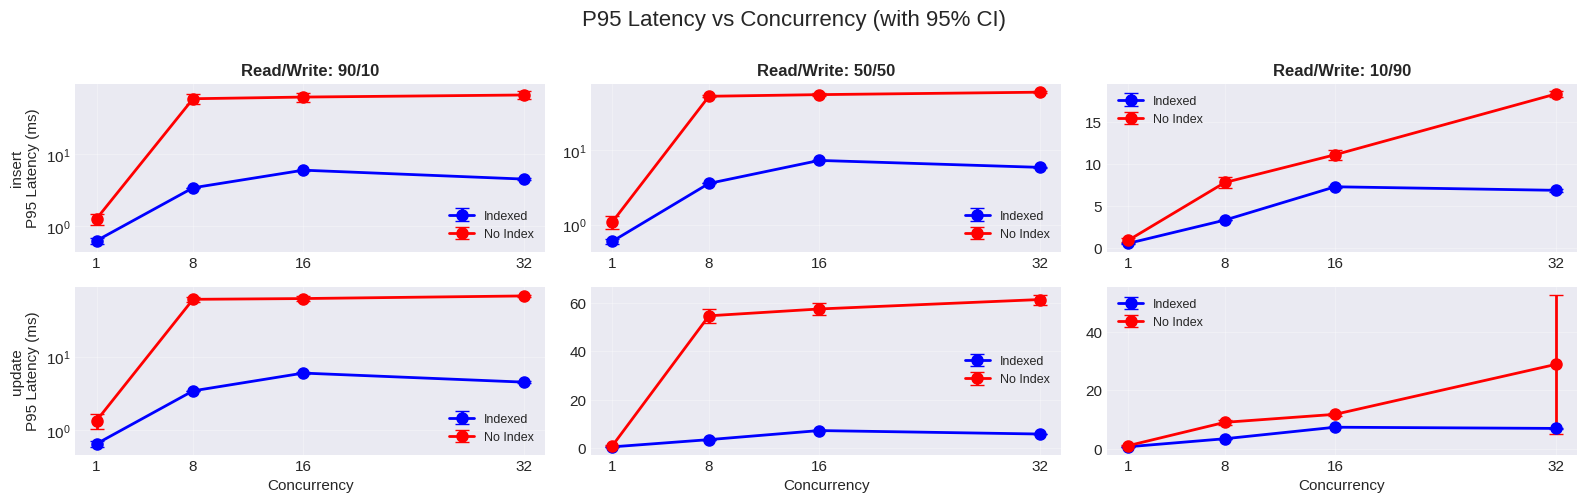

  ✓ Saved: analysis_outputs/plots/memory-resident/03_p95_latency_write_operations.png



In [218]:
# Focused view: Write operations only
print("="*80)
print("GENERATING P95 LATENCY PLOTS (WRITE OPERATIONS)")
print("="*80)

for dataset_name in sorted(stats_df['dataset'].unique()):
    print(f"\nDataset: {dataset_name}")
    
    dataset_plot_dir = PLOTS_DIR / dataset_name
    dataset_stats = stats_df[stats_df['dataset'] == dataset_name]
    
    fig = plot_p95_latency_by_ratio(
        dataset_stats, 
        operation_filter=['insert', 'update'],
        figsize=(16, 5)
    )
    display(fig)
    plot_path = dataset_plot_dir / '03_p95_latency_write_operations.png'
    fig.savefig(plot_path, dpi=PLOTS_RESOLUTION, bbox_inches='tight')
    print(f"  ✓ Saved: {plot_path}")
    plt.close(fig)

print("\n" + "="*80)

GENERATING TOTAL THROUGHPUT PLOTS

Dataset: disk-resident


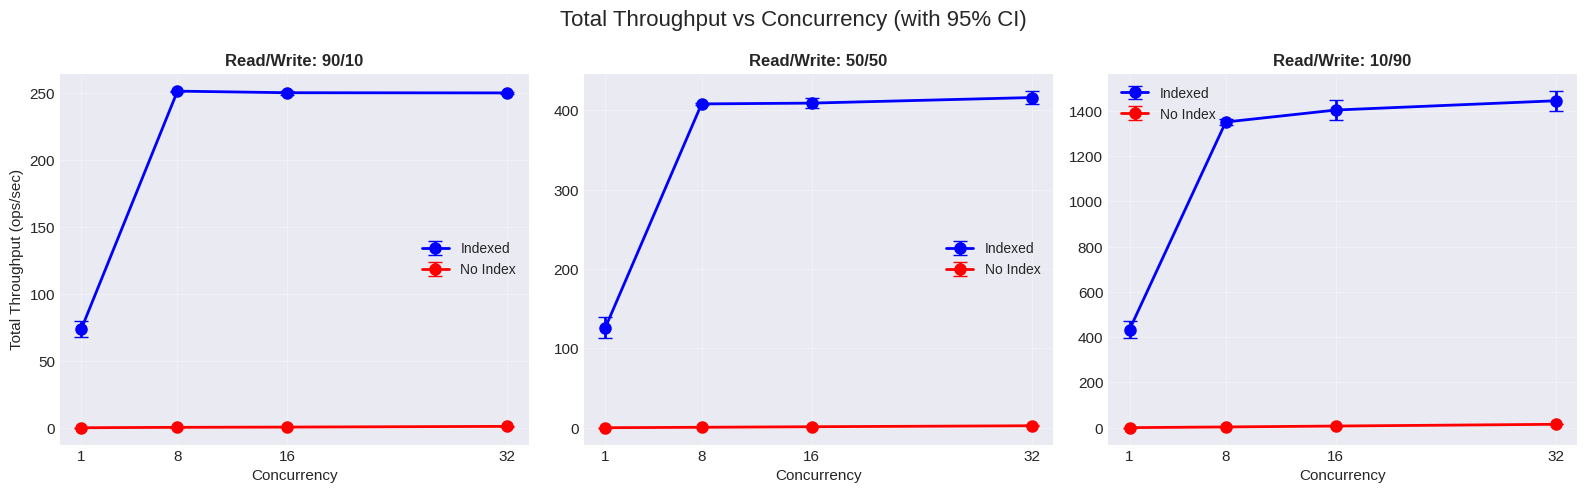

  ✓ Saved: analysis_outputs/plots/disk-resident/04_total_throughput.png

Dataset: memory-resident


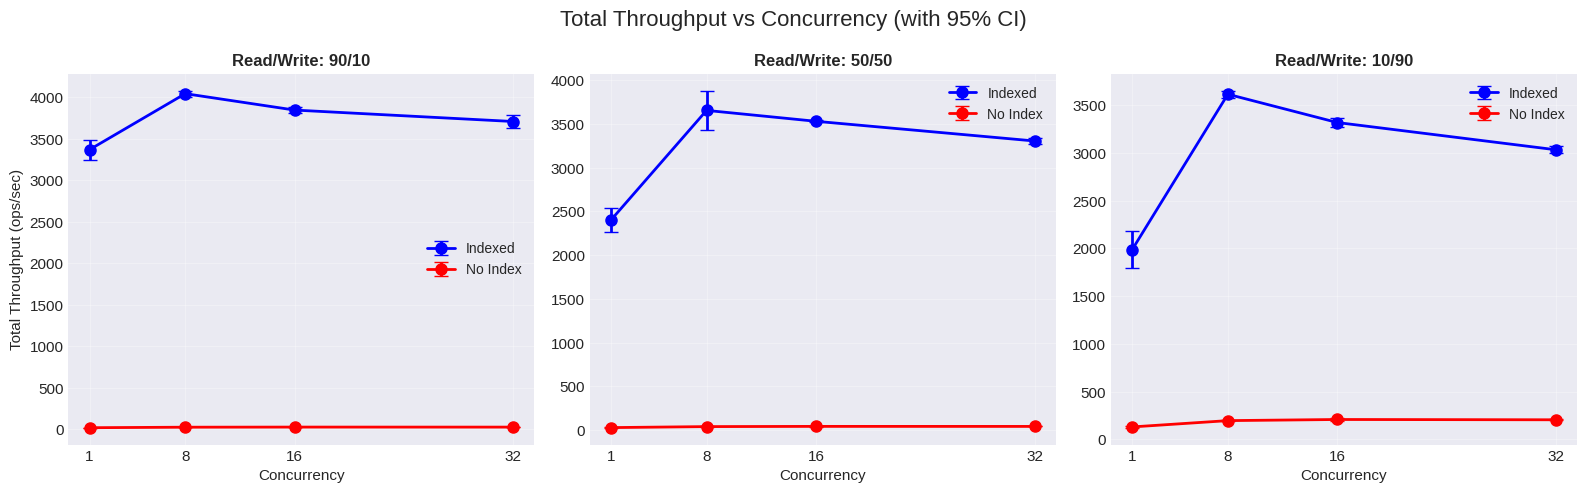

  ✓ Saved: analysis_outputs/plots/memory-resident/04_total_throughput.png



In [219]:
def plot_throughput_by_ratio(stats_df, figsize=(16, 5)):
    """
    Plot total throughput (ops/sec) vs concurrency for each ratio.
    """
    # Get total throughput (aggregate across operations for same config)
    throughput_df = stats_df.groupby(['indexed', 'index_label', 'ratio_label', 'concurrency']).agg({
        'total_ops_per_sec_mean': 'first',  # Already aggregated
        'total_ops_per_sec_ci_95': 'first'
    }).reset_index()
    
    ratios = sorted(throughput_df['ratio_label'].unique(), key=lambda x: int(x.split('/')[0]), reverse=True)
    
    fig, axes = plt.subplots(1, len(ratios), figsize=figsize, squeeze=False)
    fig.suptitle('Total Throughput vs Concurrency (with 95% CI)', fontsize=16)
    
    for ratio_idx, ratio in enumerate(ratios):
        ax = axes[0, ratio_idx]
        data = throughput_df[throughput_df['ratio_label'] == ratio]
        
        for indexed in [True, False]:
            subset = data[data['indexed'] == indexed].sort_values('concurrency')
            
            if len(subset) > 0:
                label = 'Indexed' if indexed else 'No Index'
                color = 'blue' if indexed else 'red'
                
                ax.errorbar(
                    subset['concurrency'], 
                    subset['total_ops_per_sec_mean'],
                    yerr=subset['total_ops_per_sec_ci_95'],
                    marker='o', 
                    label=label,
                    color=color,
                    capsize=5,
                    linewidth=2,
                    markersize=8
                )
        
        ax.set_title(f'Read/Write: {ratio}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Concurrency', fontsize=11)
        if ratio_idx == 0:
            ax.set_ylabel('Total Throughput (ops/sec)', fontsize=11)
        ax.set_xticks([1, 8, 16, 32])
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best', fontsize=10)
    
    plt.tight_layout()
    return fig


# Generate plots for each dataset
print("="*80)
print("GENERATING TOTAL THROUGHPUT PLOTS")
print("="*80)

for dataset_name in sorted(stats_df['dataset'].unique()):
    print(f"\nDataset: {dataset_name}")
    
    dataset_plot_dir = PLOTS_DIR / dataset_name
    dataset_stats = stats_df[stats_df['dataset'] == dataset_name]
    
    fig = plot_throughput_by_ratio(dataset_stats)
    display(fig)
    plot_path = dataset_plot_dir / '04_total_throughput.png'
    fig.savefig(plot_path, dpi=PLOTS_RESOLUTION, bbox_inches='tight')
    print(f"  ✓ Saved: {plot_path}")
    plt.close(fig)

print("\n" + "="*80)

GENERATING PER-OPERATION THROUGHPUT PLOTS

Dataset: disk-resident


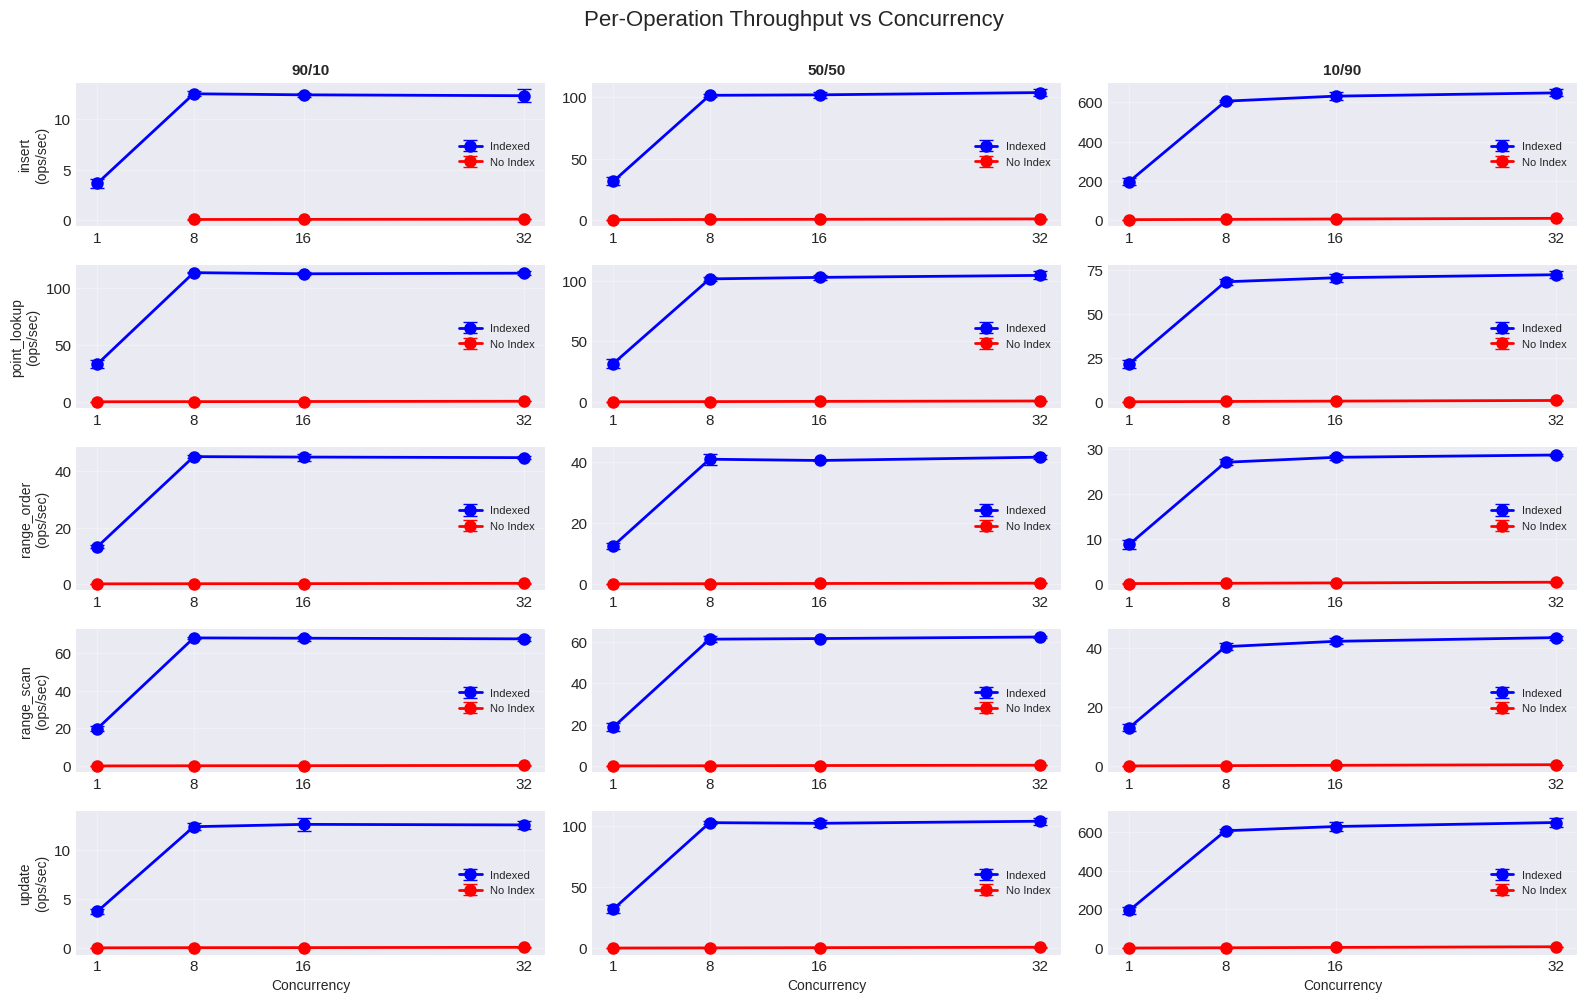

  ✓ Saved: analysis_outputs/plots/disk-resident/05_per_operation_throughput.png

Dataset: memory-resident


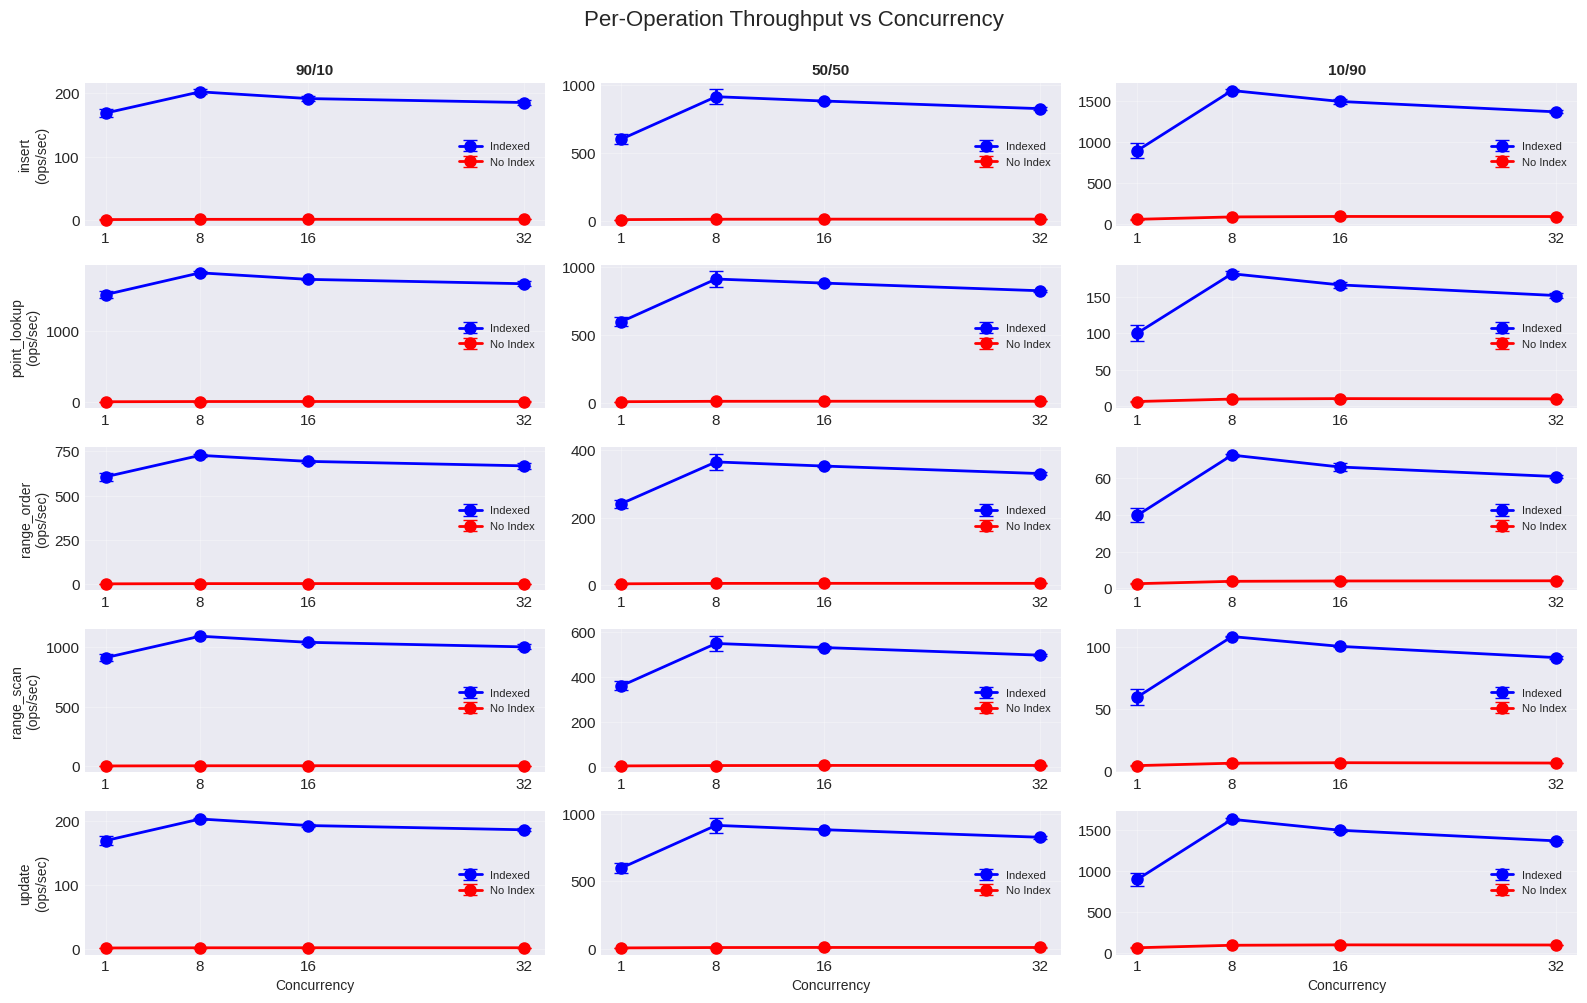

  ✓ Saved: analysis_outputs/plots/memory-resident/05_per_operation_throughput.png



In [220]:
# Per-operation throughput comparison
def plot_per_operation_throughput(stats_df, figsize=(16, 10)):
    """
    Plot per-operation throughput vs concurrency.
    """
    operations = sorted(stats_df['operation'].unique())
    ratios = sorted(stats_df['ratio_label'].unique(), key=lambda x: int(x.split('/')[0]), reverse=True)
    
    fig, axes = plt.subplots(len(operations), len(ratios), figsize=figsize, squeeze=False)
    fig.suptitle('Per-Operation Throughput vs Concurrency', fontsize=16, y=1.0)
    
    for op_idx, operation in enumerate(operations):
        for ratio_idx, ratio in enumerate(ratios):
            ax = axes[op_idx, ratio_idx]
            
            data = stats_df[(stats_df['operation'] == operation) & (stats_df['ratio_label'] == ratio)]
            
            for indexed in [True, False]:
                subset = data[data['indexed'] == indexed].sort_values('concurrency')
                
                if len(subset) > 0:
                    label = 'Indexed' if indexed else 'No Index'
                    color = 'blue' if indexed else 'red'
                    
                    ax.errorbar(
                        subset['concurrency'], 
                        subset['ops_per_sec_mean'],
                        yerr=subset['ops_per_sec_ci_95'],
                        marker='o', 
                        label=label,
                        color=color,
                        capsize=5,
                        linewidth=2,
                        markersize=8
                    )
            
            if op_idx == 0:
                ax.set_title(f'{ratio}', fontsize=11, fontweight='bold')
            if ratio_idx == 0:
                ax.set_ylabel(f'{operation}\n(ops/sec)', fontsize=10)
            if op_idx == len(operations) - 1:
                ax.set_xlabel('Concurrency', fontsize=10)
            
            ax.set_xticks([1, 8, 16, 32])
            ax.grid(True, alpha=0.3)
            ax.legend(loc='best', fontsize=8)
    
    plt.tight_layout()
    return fig


# Generate plots for each dataset
print("="*80)
print("GENERATING PER-OPERATION THROUGHPUT PLOTS")
print("="*80)

for dataset_name in sorted(stats_df['dataset'].unique()):
    print(f"\nDataset: {dataset_name}")
    
    dataset_plot_dir = PLOTS_DIR / dataset_name
    dataset_stats = stats_df[stats_df['dataset'] == dataset_name]
    
    fig = plot_per_operation_throughput(dataset_stats)
    plot_path = dataset_plot_dir / '05_per_operation_throughput.png'
    display(fig)
    fig.savefig(plot_path, dpi=PLOTS_RESOLUTION, bbox_inches='tight')
    print(f"  ✓ Saved: {plot_path}")
    plt.close(fig)

print("\n" + "="*80)

In [221]:
# Calculate index overhead for writes
def calculate_index_overhead(stats_df):
    """
    Calculate relative overhead: (indexed - no_index) / no_index * 100%
    """
    overhead_data = []
    
    for ratio in stats_df['ratio_label'].unique():
        for concurrency in stats_df['concurrency'].unique():
            for operation in stats_df['operation'].unique():
                subset = stats_df[
                    (stats_df['ratio_label'] == ratio) &
                    (stats_df['concurrency'] == concurrency) &
                    (stats_df['operation'] == operation)
                ]
                
                if len(subset) == 2:  # Both indexed and no_index present
                    indexed_row = subset[subset['indexed'] == True].iloc[0]
                    no_index_row = subset[subset['indexed'] == False].iloc[0]
                    
                    # Calculate overhead for p95 latency
                    p95_overhead = (
                        (indexed_row['p95_latency_ms_mean'] - no_index_row['p95_latency_ms_mean']) 
                        / no_index_row['p95_latency_ms_mean'] * 100
                    )
                    
                    # Calculate overhead for throughput (negative = improvement)
                    throughput_overhead = (
                        (indexed_row['ops_per_sec_mean'] - no_index_row['ops_per_sec_mean'])
                        / no_index_row['ops_per_sec_mean'] * 100
                    )
                    
                    overhead_data.append({
                        'ratio_label': ratio,
                        'concurrency': concurrency,
                        'operation': operation,
                        'op_category': indexed_row['op_category'],
                        'p95_overhead_pct': p95_overhead,
                        'throughput_overhead_pct': throughput_overhead,
                        'indexed_p95': indexed_row['p95_latency_ms_mean'],
                        'no_index_p95': no_index_row['p95_latency_ms_mean'],
                        'indexed_throughput': indexed_row['ops_per_sec_mean'],
                        'no_index_throughput': no_index_row['ops_per_sec_mean']
                    })
    
    return pd.DataFrame(overhead_data)


# Calculate and display overhead per dataset
print("="*80)
print("INDEX OVERHEAD ANALYSIS")
print("="*80)

# Store overhead dataframes for each dataset
overhead_dfs = {}

for dataset_name in sorted(stats_df['dataset'].unique()):
    print(f"\n{'='*80}")
    print(f"Dataset: {dataset_name.upper()}")
    print(f"{'='*80}")
    
    dataset_stats = stats_df[stats_df['dataset'] == dataset_name]
    overhead_df = calculate_index_overhead(dataset_stats)
    overhead_dfs[dataset_name] = overhead_df
    
    print("\nIndex Overhead Summary (negative = index is better):")
    print("\nBy Operation Type:")
    display(overhead_df.groupby('operation')[['p95_overhead_pct', 'throughput_overhead_pct']].mean().round(2))
    
    print("\nBy Read/Write Category:")
    display(overhead_df.groupby('op_category')[['p95_overhead_pct', 'throughput_overhead_pct']].mean().round(2))

print("\n" + "="*80)

INDEX OVERHEAD ANALYSIS

Dataset: DISK-RESIDENT

Index Overhead Summary (negative = index is better):

By Operation Type:


,p95_overhead_pct,throughput_overhead_pct
operation,,
insert,106.05,54618.69
point_lookup,-99.99,74329.83
range_order,-99.65,71507.07
range_scan,804.97,81127.45
update,60.28,56230.21



By Read/Write Category:


,p95_overhead_pct,throughput_overhead_pct
op_category,,
read,201.78,75654.79
write,82.17,55459.49



Dataset: MEMORY-RESIDENT

Index Overhead Summary (negative = index is better):

By Operation Type:


,p95_overhead_pct,throughput_overhead_pct
operation,,
insert,-69.74,9442.46
point_lookup,-99.82,9212.64
range_order,-99.63,9260.74
range_scan,-53.31,9252.97
update,-71.62,9129.68



By Read/Write Category:


,p95_overhead_pct,throughput_overhead_pct
op_category,,
read,-84.25,9242.12
write,-70.68,9286.07


GENERATING WRITE OVERHEAD PLOTS

Dataset: disk-resident


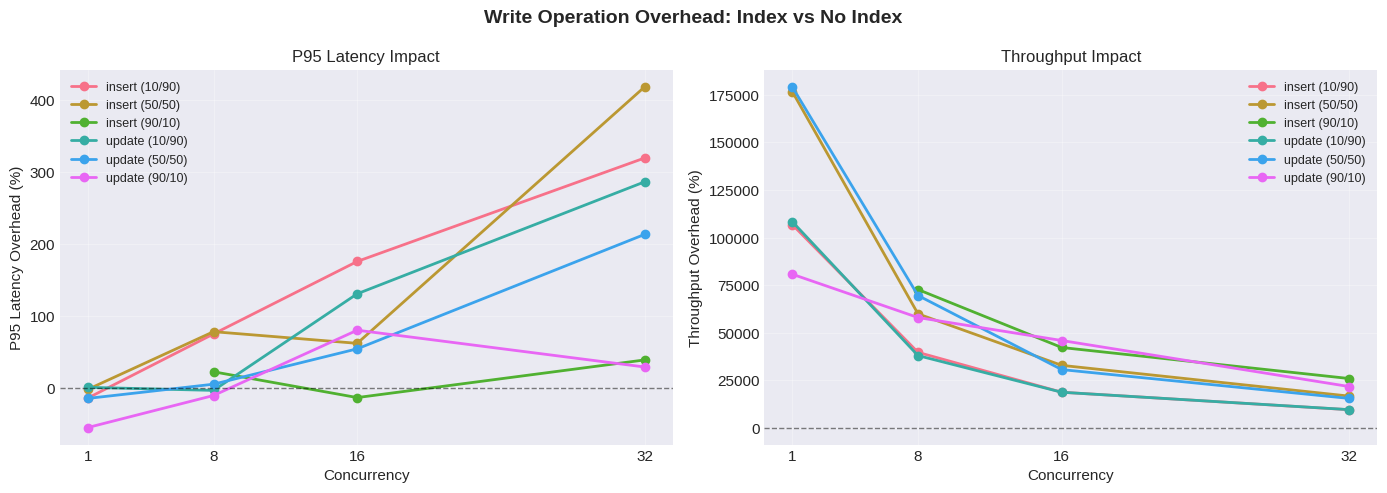

  ✓ Saved: analysis_outputs/plots/disk-resident/06_write_overhead.png

Dataset: memory-resident


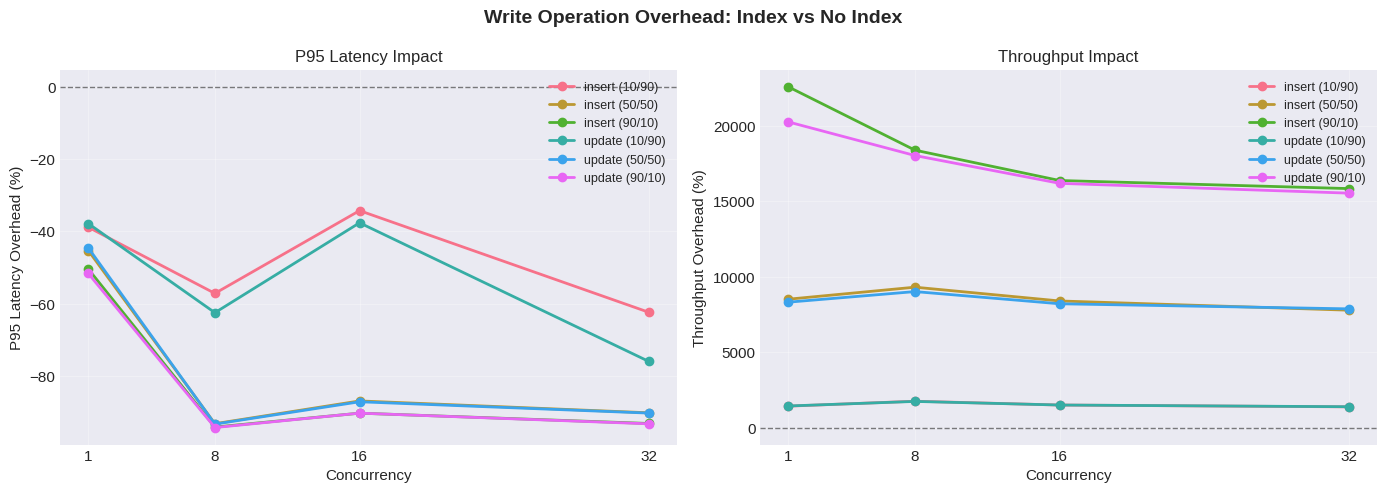

  ✓ Saved: analysis_outputs/plots/memory-resident/06_write_overhead.png



In [222]:
# Plot write operation overhead
def plot_write_overhead(overhead_df, figsize=(14, 5)):
    """
    Plot write operation overhead across configurations.
    """
    write_ops = overhead_df[overhead_df['op_category'] == 'write']
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('Write Operation Overhead: Index vs No Index', fontsize=14, fontweight='bold')
    
    # P95 Latency Overhead
    ax = axes[0]
    for operation in write_ops['operation'].unique():
        op_data = write_ops[write_ops['operation'] == operation]
        for ratio in sorted(op_data['ratio_label'].unique()):
            subset = op_data[op_data['ratio_label'] == ratio].sort_values('concurrency')
            ax.plot(
                subset['concurrency'],
                subset['p95_overhead_pct'],
                marker='o',
                label=f'{operation} ({ratio})',
                linewidth=2,
                markersize=6
            )
    
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
    ax.set_xlabel('Concurrency', fontsize=11)
    ax.set_ylabel('P95 Latency Overhead (%)', fontsize=11)
    ax.set_title('P95 Latency Impact', fontsize=12)
    ax.set_xticks([1, 8, 16, 32])
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, loc='best')
    
    # Throughput Overhead
    ax = axes[1]
    for operation in write_ops['operation'].unique():
        op_data = write_ops[write_ops['operation'] == operation]
        for ratio in sorted(op_data['ratio_label'].unique()):
            subset = op_data[op_data['ratio_label'] == ratio].sort_values('concurrency')
            ax.plot(
                subset['concurrency'],
                subset['throughput_overhead_pct'],
                marker='o',
                label=f'{operation} ({ratio})',
                linewidth=2,
                markersize=6
            )
    
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
    ax.set_xlabel('Concurrency', fontsize=11)
    ax.set_ylabel('Throughput Overhead (%)', fontsize=11)
    ax.set_title('Throughput Impact', fontsize=12)
    ax.set_xticks([1, 8, 16, 32])
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, loc='best')
    
    plt.tight_layout()
    return fig


# Generate plots for each dataset
print("="*80)
print("GENERATING WRITE OVERHEAD PLOTS")
print("="*80)

for dataset_name in sorted(overhead_dfs.keys()):
    print(f"\nDataset: {dataset_name}")
    
    dataset_plot_dir = PLOTS_DIR / dataset_name
    overhead_df = overhead_dfs[dataset_name]
    
    fig = plot_write_overhead(overhead_df)
    display(fig)
    plot_path = dataset_plot_dir / '06_write_overhead.png'
    fig.savefig(plot_path, dpi=PLOTS_RESOLUTION, bbox_inches='tight')
    print(f"  ✓ Saved: {plot_path}")
    plt.close(fig)

print("\n" + "="*80)

GENERATING P95 LATENCY OVERHEAD HEATMAPS

Dataset: disk-resident


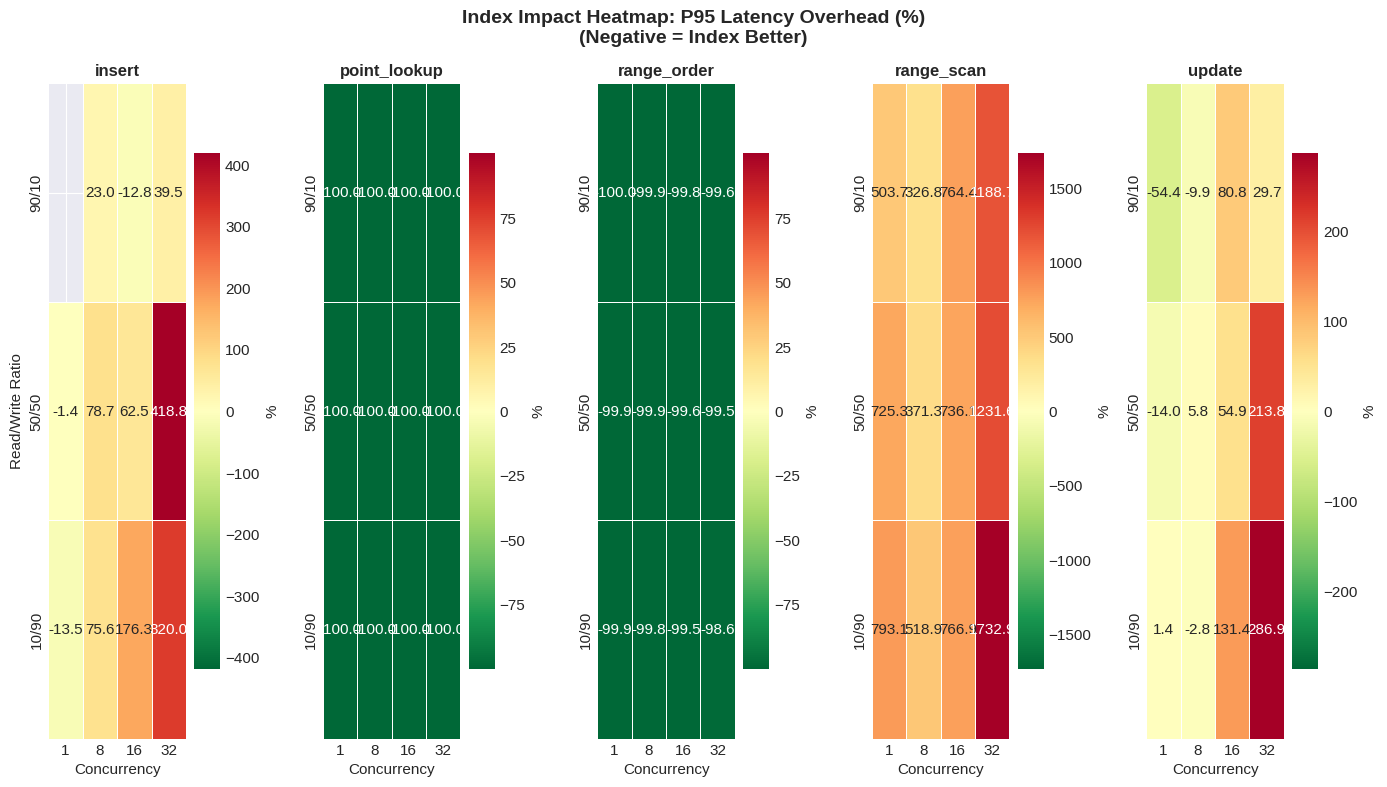

  ✓ Saved: analysis_outputs/plots/disk-resident/07_heatmap_p95_overhead.png

Dataset: memory-resident


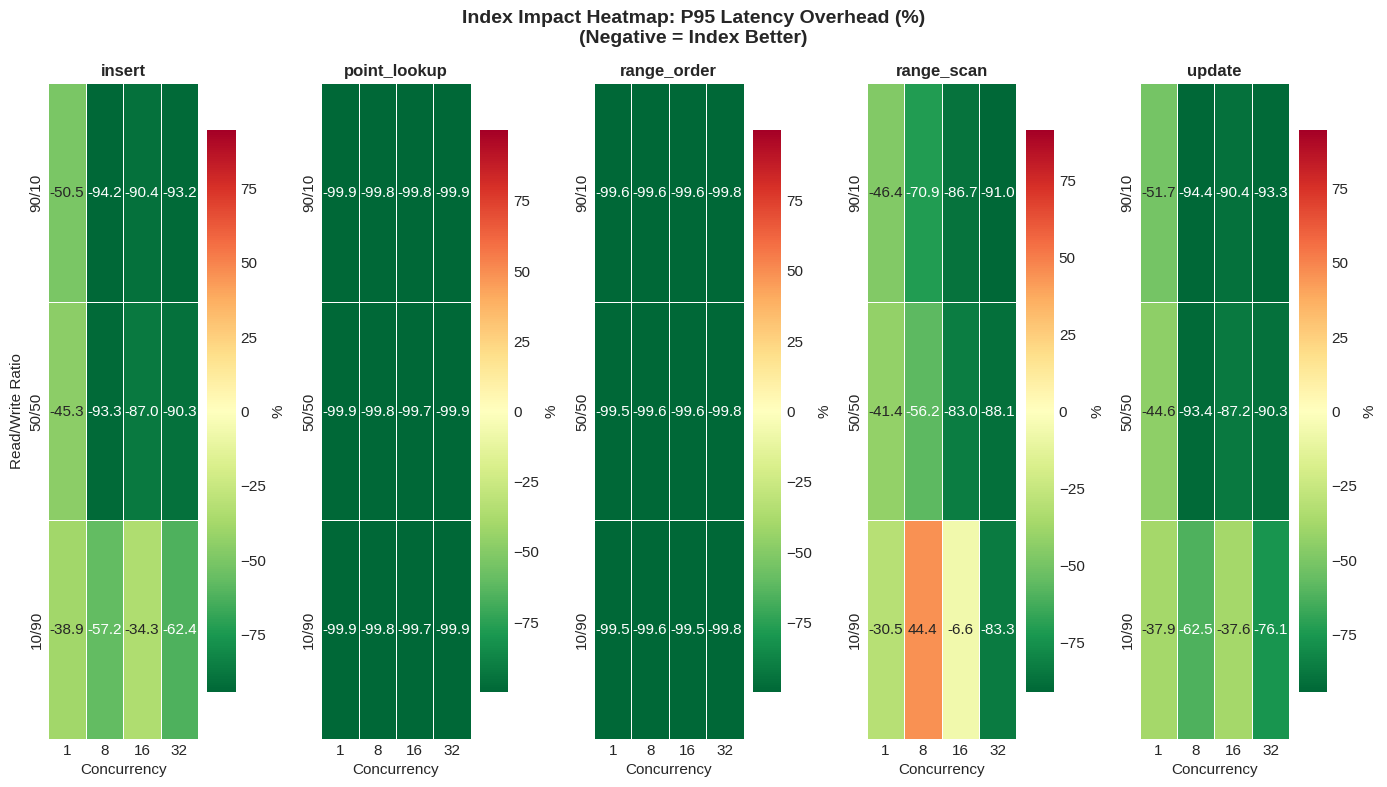

  ✓ Saved: analysis_outputs/plots/memory-resident/07_heatmap_p95_overhead.png



In [223]:
def plot_index_benefit_heatmap(overhead_df, metric='p95_overhead_pct', figsize=(14, 8)):
    """
    Heatmap showing index benefit (negative = index wins) across ratio × concurrency.
    """
    operations = sorted(overhead_df['operation'].unique())
    n_ops = len(operations)
    
    fig, axes = plt.subplots(1, n_ops, figsize=figsize)
    if n_ops == 1:
        axes = [axes]
    
    title_map = {
        'p95_overhead_pct': 'P95 Latency Overhead (%)',
        'throughput_overhead_pct': 'Throughput Change (%)'
    }
    
    fig.suptitle(f'Index Impact Heatmap: {title_map.get(metric, metric)}\n(Negative = Index Better)', 
                 fontsize=14, fontweight='bold')
    
    for idx, operation in enumerate(operations):
        ax = axes[idx]
        
        # Pivot data for heatmap
        op_data = overhead_df[overhead_df['operation'] == operation]
        pivot = op_data.pivot_table(
            values=metric,
            index='ratio_label',
            columns='concurrency',
            aggfunc='mean'
        )
        
        # Sort by read ratio descending
        pivot = pivot.sort_index(key=lambda x: x.map(lambda s: int(s.split('/')[0])), ascending=False)
        
        # Create heatmap
        vmax = max(abs(pivot.min().min()), abs(pivot.max().max()))
        sns.heatmap(
            pivot,
            annot=True,
            fmt='.1f',
            cmap='RdYlGn_r',  # Red = bad (higher overhead), Green = good (lower overhead)
            center=0,
            vmin=-vmax,
            vmax=vmax,
            ax=ax,
            cbar_kws={'label': '%'},
            linewidths=0.5
        )
        
        ax.set_title(f'{operation}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Concurrency', fontsize=11)
        if idx == 0:
            ax.set_ylabel('Read/Write Ratio', fontsize=11)
        else:
            ax.set_ylabel('')
    
    plt.tight_layout()
    return fig


# P95 latency overhead heatmap
print("="*80)
print("GENERATING P95 LATENCY OVERHEAD HEATMAPS")
print("="*80)

for dataset_name in sorted(overhead_dfs.keys()):
    print(f"\nDataset: {dataset_name}")
    
    dataset_plot_dir = PLOTS_DIR / dataset_name
    overhead_df = overhead_dfs[dataset_name]
    
    fig = plot_index_benefit_heatmap(overhead_df, metric='p95_overhead_pct')
    display(fig)
    plot_path = dataset_plot_dir / '07_heatmap_p95_overhead.png'
    fig.savefig(plot_path, dpi=PLOTS_RESOLUTION, bbox_inches='tight')
    print(f"  ✓ Saved: {plot_path}")
    plt.close(fig)

print("\n" + "="*80)

In [224]:
# Throughput overhead heatmap
print("="*80)
print("GENERATING THROUGHPUT OVERHEAD HEATMAPS")
print("="*80)

for dataset_name in sorted(overhead_dfs.keys()):
    print(f"\nDataset: {dataset_name}")
    
    dataset_plot_dir = PLOTS_DIR / dataset_name
    overhead_df = overhead_dfs[dataset_name]
    
    fig = plot_index_benefit_heatmap(overhead_df, metric='throughput_overhead_pct')
    plot_path = dataset_plot_dir / '08_heatmap_throughput_overhead.png'
    fig.savefig(plot_path, dpi=PLOTS_RESOLUTION, bbox_inches='tight')
    print(f"  ✓ Saved: {plot_path}")
    plt.close(fig)

print("\n" + "="*80)

GENERATING THROUGHPUT OVERHEAD HEATMAPS

Dataset: disk-resident
  ✓ Saved: analysis_outputs/plots/disk-resident/08_heatmap_throughput_overhead.png

Dataset: memory-resident
  ✓ Saved: analysis_outputs/plots/memory-resident/08_heatmap_throughput_overhead.png



## 7. Concurrency Scaling Analysis

In [225]:
# Analyze scalability: throughput increase from c1 to c32
def analyze_scalability(stats_df):
    """
    Calculate scalability factor: throughput@c32 / throughput@c1
    """
    scalability_data = []
    
    for indexed in [True, False]:
        for ratio in stats_df['ratio_label'].unique():
            for operation in stats_df['operation'].unique():
                subset = stats_df[
                    (stats_df['indexed'] == indexed) &
                    (stats_df['ratio_label'] == ratio) &
                    (stats_df['operation'] == operation)
                ]
                
                c1 = subset[subset['concurrency'] == 1]
                c32 = subset[subset['concurrency'] == 32]
                
                if len(c1) > 0 and len(c32) > 0:
                    scalability_factor = c32.iloc[0]['ops_per_sec_mean'] / c1.iloc[0]['ops_per_sec_mean']
                    
                    scalability_data.append({
                        'indexed': indexed,
                        'index_label': 'Indexed' if indexed else 'No Index',
                        'ratio_label': ratio,
                        'operation': operation,
                        'scalability_factor': scalability_factor,
                        'throughput_c1': c1.iloc[0]['ops_per_sec_mean'],
                        'throughput_c32': c32.iloc[0]['ops_per_sec_mean']
                    })
    
    return pd.DataFrame(scalability_data)


# Calculate scalability per dataset
print("="*80)
print("CONCURRENCY SCALING ANALYSIS")
print("="*80)

# Store scalability dataframes for each dataset
scalability_dfs = {}

for dataset_name in sorted(stats_df['dataset'].unique()):
    print(f"\n{'='*80}")
    print(f"Dataset: {dataset_name.upper()}")
    print(f"{'='*80}")
    
    dataset_stats = stats_df[stats_df['dataset'] == dataset_name]
    scalability_df = analyze_scalability(dataset_stats)
    scalability_dfs[dataset_name] = scalability_df
    
    print("\nScalability Analysis (Throughput @ c32 / Throughput @ c1):")
    print("\nBy Operation and Index:")
    display(
        scalability_df.pivot_table(
            values='scalability_factor',
            index='operation',
            columns='index_label',
            aggfunc='mean'
        ).round(2)
    )
    
    print("\nDetailed Scalability by Configuration:")
    display(scalability_df.sort_values(['operation', 'ratio_label', 'indexed']))

print("\n" + "="*80)

CONCURRENCY SCALING ANALYSIS

Dataset: DISK-RESIDENT

Scalability Analysis (Throughput @ c32 / Throughput @ c1):

By Operation and Index:


index_label,Indexed,No Index
operation,,
insert,3.34,36.32
point_lookup,3.35,35.24
range_order,3.33,33.73
range_scan,3.36,40.28
update,3.32,29.46



Detailed Scalability by Configuration:


,indexed,index_label,ratio_label,operation,scalability_factor,throughput_c1,throughput_c32
15,False,No Index,10/90,insert,37.496740,0.182548,6.844971
0,True,Indexed,10/90,insert,3.326746,195.151401,649.219194
20,False,No Index,50/50,insert,35.152192,0.017770,0.624641
5,True,Indexed,50/50,insert,3.307167,31.438297,103.971693
10,True,Indexed,90/10,insert,3.398890,3.637596,12.363789
16,False,No Index,10/90,point_lookup,34.320596,0.021784,0.747651
1,True,Indexed,10/90,point_lookup,3.340297,21.566333,72.037966
21,False,No Index,50/50,point_lookup,26.762825,0.024433,0.653906
6,True,Indexed,50/50,point_lookup,3.303517,31.610507,104.425848
25,False,No Index,90/10,point_lookup,44.651304,0.010263,0.458241



Dataset: MEMORY-RESIDENT

Scalability Analysis (Throughput @ c32 / Throughput @ c1):

By Operation and Index:


index_label,Indexed,No Index
operation,,
insert,1.33,1.55
point_lookup,1.33,1.50
range_order,1.33,1.54
range_scan,1.34,1.47
update,1.34,1.49



Detailed Scalability by Configuration:


,indexed,index_label,ratio_label,operation,scalability_factor,throughput_c1,throughput_c32
15,False,No Index,10/90,insert,1.572707,58.955752,92.720097
0,True,Indexed,10/90,insert,1.525152,895.940497,1366.445770
20,False,No Index,50/50,insert,1.500558,6.974571,10.465750
5,True,Indexed,50/50,insert,1.373403,600.983175,825.392002
25,False,No Index,90/10,insert,1.563339,0.744258,1.163528
10,True,Indexed,90/10,insert,1.098610,168.986110,185.649809
16,False,No Index,10/90,point_lookup,1.567276,6.454962,10.116709
1,True,Indexed,10/90,point_lookup,1.512890,100.085239,151.417966
21,False,No Index,50/50,point_lookup,1.467021,7.104556,10.422535
6,True,Indexed,50/50,point_lookup,1.380784,598.189853,825.970837


## 8. Key Findings Summary

In [226]:
# Generate summary statistics for key findings per dataset
print("="*80)
print("KEY FINDINGS SUMMARY")
print("="*80)

for dataset_name in sorted(stats_df['dataset'].unique()):
    dataset_stats = stats_df[stats_df['dataset'] == dataset_name]
    dataset_df = df[df['dataset'] == dataset_name]
    
    print(f"\n{'='*80}")
    print(f"Dataset: {dataset_name.upper()}")
    print(f"{'='*80}")

    print("\n1. READ OPERATION PERFORMANCE (P95 Latency)")
    print("-" * 80)
    read_ops = dataset_stats[dataset_stats['op_category'] == 'read']
    for operation in ['point_lookup', 'range_scan', 'range_order']:
        op_data = read_ops[read_ops['operation'] == operation]
        if len(op_data) > 0:
            indexed = op_data[op_data['indexed'] == True]['p95_latency_ms_mean'].mean()
            no_index = op_data[op_data['indexed'] == False]['p95_latency_ms_mean'].mean()
            improvement = (no_index - indexed) / no_index * 100
            
            print(f"\n{operation}:")
            print(f"  Indexed avg P95:    {indexed:.2f} ms")
            print(f"  No Index avg P95:   {no_index:.2f} ms")
            print(f"  Index improvement:  {improvement:+.1f}%")

    print("\n\n2. WRITE OPERATION PERFORMANCE (P95 Latency)")
    print("-" * 80)
    write_ops = dataset_stats[dataset_stats['op_category'] == 'write']
    for operation in ['insert', 'update']:
        op_data = write_ops[write_ops['operation'] == operation]
        if len(op_data) > 0:
            indexed = op_data[op_data['indexed'] == True]['p95_latency_ms_mean'].mean()
            no_index = op_data[op_data['indexed'] == False]['p95_latency_ms_mean'].mean()
            overhead = (indexed - no_index) / no_index * 100
            
            print(f"\n{operation}:")
            print(f"  Indexed avg P95:    {indexed:.2f} ms")
            print(f"  No Index avg P95:   {no_index:.2f} ms")
            print(f"  Index overhead:     {overhead:+.1f}%")

    print("\n\n3. OVERALL THROUGHPUT")
    print("-" * 80)
    throughput_summary = dataset_stats.groupby(['indexed', 'ratio_label']).agg({
        'total_ops_per_sec_mean': 'first'
    }).reset_index()

    for ratio in sorted(throughput_summary['ratio_label'].unique()):
        ratio_data = throughput_summary[throughput_summary['ratio_label'] == ratio]
        indexed = ratio_data[ratio_data['indexed'] == True]['total_ops_per_sec_mean'].mean()
        no_index = ratio_data[ratio_data['indexed'] == False]['total_ops_per_sec_mean'].mean()
        change = (indexed - no_index) / no_index * 100
        
        print(f"\nRatio {ratio}:")
        print(f"  Indexed avg:    {indexed:.2f} ops/sec")
        print(f"  No Index avg:   {no_index:.2f} ops/sec")
        print(f"  Change:         {change:+.1f}%")

    print("\n\n4. ERROR RATES")
    print("-" * 80)
    total_ops = dataset_df['count'].sum()
    total_errors = dataset_df['error'].sum()
    error_rate = total_errors / total_ops * 100 if total_ops > 0 else 0

    print(f"Total operations:  {total_ops:,}")
    print(f"Total errors:      {total_errors:,}")
    print(f"Error rate:        {error_rate:.4f}%")

    if total_errors > 0:
        print("\nError breakdown by type:")
        print(f"  Statement timeouts: {dataset_df['timeout_statement'].sum()}")
        print(f"  Lock timeouts:      {dataset_df['timeout_lock'].sum()}")
        print(f"  Deadlocks:          {dataset_df['deadlock'].sum()}")
        print(f"  Other errors:       {dataset_df['error_other'].sum()}")

print("\n" + "="*80)

KEY FINDINGS SUMMARY

Dataset: DISK-RESIDENT

1. READ OPERATION PERFORMANCE (P95 Latency)
--------------------------------------------------------------------------------

point_lookup:
  Indexed avg P95:    3.95 ms
  No Index avg P95:   54769.49 ms
  Index improvement:  +100.0%

range_scan:
  Indexed avg P95:    158.55 ms
  No Index avg P95:   16.24 ms
  Index improvement:  -876.6%

range_order:
  Indexed avg P95:    158.56 ms
  No Index avg P95:   52326.03 ms
  Index improvement:  +99.7%


2. WRITE OPERATION PERFORMANCE (P95 Latency)
--------------------------------------------------------------------------------

insert:
  Indexed avg P95:    9.08 ms
  No Index avg P95:   3.92 ms
  Index overhead:     +131.5%

update:
  Indexed avg P95:    12.10 ms
  No Index avg P95:   6.61 ms
  Index overhead:     +82.9%


3. OVERALL THROUGHPUT
--------------------------------------------------------------------------------

Ratio 10/90:
  Indexed avg:    433.59 ops/sec
  No Index avg:   0.40 ops/

## 9. Decision Recommendations

Based on the analysis above, generate actionable recommendations.

In [227]:
# Generate decision matrix
def generate_recommendations(overhead_df, stats_df):
    """
    Generate recommendations based on comprehensive overhead analysis.
    
    Decision criteria (in priority order):
    1. Timeouts: If no-index configuration has timeouts, index is REQUIRED
    2. Critical operations: Point lookups and ordered queries must be fast
    3. Throughput: Consider overall system throughput improvements
    4. Latency: Balance read improvements vs write overhead
    """
    recommendations = []
    
    # Group by ratio and concurrency
    for ratio in sorted(overhead_df['ratio_label'].unique()):
        for concurrency in sorted(overhead_df['concurrency'].unique()):
            subset = overhead_df[
                (overhead_df['ratio_label'] == ratio) &
                (overhead_df['concurrency'] == concurrency)
            ]
            
            # Get timeout counts for no-index configuration
            no_index_timeouts = stats_df[
                (stats_df['indexed'] == False) &
                (stats_df['ratio_label'] == ratio) &
                (stats_df['concurrency'] == concurrency)
            ]
            total_timeouts = 0
            if len(no_index_timeouts) > 0:
                total_timeouts = (
                    no_index_timeouts['timeout_statement_sum'].sum() + 
                    no_index_timeouts['timeout_lock_sum'].sum()
                )
            
            # Calculate operation-specific metrics
            read_overhead = subset[subset['op_category'] == 'read']['p95_overhead_pct'].mean()
            write_overhead = subset[subset['op_category'] == 'write']['p95_overhead_pct'].mean()
            
            # Get critical operation metrics (point_lookup and range_order)
            critical_ops = subset[subset['operation'].isin(['point_lookup', 'range_order'])]
            critical_overhead = critical_ops['p95_overhead_pct'].mean() if len(critical_ops) > 0 else 0
            
            # Get throughput improvement (indexed vs no-index)
            throughput_improvement = subset['throughput_overhead_pct'].mean()
            
            # Decision logic with priority ordering
            if total_timeouts > 0:
                decision = "✓ Use Index"
                reason = f"CRITICAL: {total_timeouts} timeouts without index (system unusable)"
                priority = "P0 - Required"
                
            elif critical_overhead < -50:  # Critical ops improve by >50%
                decision = "✓ Use Index"
                reason = f"Critical operations improve by {-critical_overhead:.0f}%"
                priority = "P1 - Highly Recommended"
                
            elif throughput_improvement > 1000:  # >10x throughput improvement
                decision = "✓ Use Index"
                reason = f"Throughput improves by {throughput_improvement:.0f}%"
                priority = "P1 - Highly Recommended"
                
            elif read_overhead < -30 and write_overhead < 200:  # Read improvement outweighs write cost
                decision = "✓ Use Index"
                reason = f"Read latency -{-read_overhead:.0f}% vs write +{write_overhead:.0f}%"
                priority = "P2 - Recommended"
                
            elif write_overhead > 100 and read_overhead > -20:  # High write cost, minimal read benefit
                decision = "✗ Skip Index"
                reason = f"High write overhead (+{write_overhead:.0f}%) with minimal read benefit"
                priority = "P3 - Not Recommended"
                
            else:
                decision = "~ Marginal"
                reason = f"Mixed impact: read {read_overhead:+.0f}%, write {write_overhead:+.0f}%"
                priority = "P4 - Case-by-case"
            
            recommendations.append({
                'ratio': ratio,
                'concurrency': concurrency,
                'read_overhead_pct': read_overhead,
                'write_overhead_pct': write_overhead,
                'critical_ops_overhead_pct': critical_overhead,
                'throughput_improvement_pct': throughput_improvement,
                'no_index_timeouts': total_timeouts,
                'decision': decision,
                'priority': priority,
                'reason': reason
            })
    
    return pd.DataFrame(recommendations)


# Generate recommendations per dataset
print("="*80)
print("DECISION MATRIX: When to Use Index?")
print("="*80)
print("Legend: ✓ = Use Index | ✗ = Skip Index | ~ = Marginal benefit")
print("        P0 = Required | P1 = Highly Recommended | P2 = Recommended | P3 = Not Recommended | P4 = Case-by-case")
print("="*80)

# Store recommendations dataframes for each dataset
recommendations_dfs = {}

for dataset_name in sorted(stats_df['dataset'].unique()):
    print(f"\n{'='*80}")
    print(f"Dataset: {dataset_name.upper()}")
    print(f"{'='*80}")
    
    dataset_stats = stats_df[stats_df['dataset'] == dataset_name]
    overhead_df = overhead_dfs[dataset_name]
    
    recommendations_df = generate_recommendations(overhead_df, dataset_stats)
    recommendations_dfs[dataset_name] = recommendations_df
    
    display(recommendations_df.sort_values(['ratio', 'concurrency']))
    
    print("\n" + "-"*80)
    print(f"SUMMARY for {dataset_name}")
    print("-"*80)
    
    use_index_count = len(recommendations_df[recommendations_df['decision'] == '✓ Use Index'])
    skip_index_count = len(recommendations_df[recommendations_df['decision'] == '✗ Skip Index'])
    marginal_count = len(recommendations_df[recommendations_df['decision'] == '~ Marginal'])
    
    print(f"\nOut of {len(recommendations_df)} tested configurations:")
    print(f"  ✓ Index beneficial:  {use_index_count} ({use_index_count/len(recommendations_df)*100:.1f}%)")
    print(f"  ✗ Index detrimental: {skip_index_count} ({skip_index_count/len(recommendations_df)*100:.1f}%)")
    print(f"  ~ Marginal impact:   {marginal_count} ({marginal_count/len(recommendations_df)*100:.1f}%)")
    
    # Extract patterns by priority
    print("\nDecision Breakdown by Priority:")
    priority_counts = recommendations_df['priority'].value_counts().sort_index()
    for priority, count in priority_counts.items():
        print(f"  {priority}: {count} configurations")
    
    # Show configurations with timeouts
    timeout_configs = recommendations_df[recommendations_df['no_index_timeouts'] > 0]
    if len(timeout_configs) > 0:
        print(f"\n⚠️  CRITICAL: {len(timeout_configs)} configurations have timeouts without index")
        print("   These configurations are UNUSABLE without indexing:")
        for _, row in timeout_configs.iterrows():
            print(f"     • {row['ratio']} ratio, concurrency {row['concurrency']}: {row['no_index_timeouts']} timeouts")

print("\n" + "="*80)

DECISION MATRIX: When to Use Index?
Legend: ✓ = Use Index | ✗ = Skip Index | ~ = Marginal benefit
        P0 = Required | P1 = Highly Recommended | P2 = Recommended | P3 = Not Recommended | P4 = Case-by-case

Dataset: DISK-RESIDENT


,ratio,concurrency,read_overhead_pct,write_overhead_pct,critical_ops_overhead_pct,throughput_improvement_pct,no_index_timeouts,decision,priority,reason
0,10/90,1,197.731575,-6.052440,-99.936783,103808.345171,21,✓ Use Index,P0 - Required,CRITICAL: 21 timeouts without index (system un...
1,10/90,8,106.365994,36.359378,-99.896602,37538.391963,231,✓ Use Index,P0 - Required,CRITICAL: 231 timeouts without index (system u...
2,10/90,16,189.162361,153.821483,-99.727030,18511.578648,480,✓ Use Index,P0 - Required,CRITICAL: 480 timeouts without index (system u...
3,10/90,32,511.438828,303.418490,-99.278253,9508.870182,960,✓ Use Index,P0 - Required,CRITICAL: 960 timeouts without index (system u...
4,50/50,1,175.134191,-7.714541,-99.938815,151175.772793,30,✓ Use Index,P0 - Required,CRITICAL: 30 timeouts without index (system un...
5,50/50,8,57.140729,42.235845,-99.924948,66134.630053,177,✓ Use Index,P0 - Required,CRITICAL: 177 timeouts without index (system u...
6,50/50,16,178.813209,58.725114,-99.805901,30920.741483,426,✓ Use Index,P0 - Required,CRITICAL: 426 timeouts without index (system u...
7,50/50,32,344.031834,316.299045,-99.750864,16422.300562,816,✓ Use Index,P0 - Required,CRITICAL: 816 timeouts without index (system u...
8,90/10,1,101.255299,-54.437003,-99.975109,272511.539495,3,✓ Use Index,P0 - Required,CRITICAL: 3 timeouts without index (system unu...
9,90/10,8,42.289268,6.555329,-99.943419,75396.528719,123,✓ Use Index,P0 - Required,CRITICAL: 123 timeouts without index (system u...



--------------------------------------------------------------------------------
SUMMARY for disk-resident
--------------------------------------------------------------------------------

Out of 12 tested configurations:
  ✓ Index beneficial:  12 (100.0%)
  ✗ Index detrimental: 0 (0.0%)
  ~ Marginal impact:   0 (0.0%)

Decision Breakdown by Priority:
  P0 - Required: 12 configurations

⚠️  CRITICAL: 12 configurations have timeouts without index
   These configurations are UNUSABLE without indexing:
     • 10/90 ratio, concurrency 1: 21 timeouts
     • 10/90 ratio, concurrency 8: 231 timeouts
     • 10/90 ratio, concurrency 16: 480 timeouts
     • 10/90 ratio, concurrency 32: 960 timeouts
     • 50/50 ratio, concurrency 1: 30 timeouts
     • 50/50 ratio, concurrency 8: 177 timeouts
     • 50/50 ratio, concurrency 16: 426 timeouts
     • 50/50 ratio, concurrency 32: 816 timeouts
     • 90/10 ratio, concurrency 1: 3 timeouts
     • 90/10 ratio, concurrency 8: 123 timeouts
     • 90/10 r

,ratio,concurrency,read_overhead_pct,write_overhead_pct,critical_ops_overhead_pct,throughput_improvement_pct,no_index_timeouts,decision,priority,reason
0,10/90,1,-76.613670,-38.367400,-99.676073,1430.624875,0,✓ Use Index,P1 - Highly Recommended,Critical operations improve by 100%
1,10/90,8,-51.664915,-59.869379,-99.697873,1748.564524,0,✓ Use Index,P1 - Highly Recommended,Critical operations improve by 100%
2,10/90,16,-68.618401,-35.962954,-99.623992,1501.079400,0,✓ Use Index,P1 - Highly Recommended,Critical operations improve by 100%
3,10/90,32,-94.300760,-69.245188,-99.817441,1386.466941,0,✓ Use Index,P1 - Highly Recommended,Critical operations improve by 100%
4,50/50,1,-80.263714,-44.972588,-99.703053,8453.879500,0,✓ Use Index,P1 - Highly Recommended,Critical operations improve by 100%
5,50/50,8,-85.189918,-93.340330,-99.684988,9139.654631,0,✓ Use Index,P1 - Highly Recommended,Critical operations improve by 100%
6,50/50,16,-94.089821,-87.095783,-99.638093,8289.110886,0,✓ Use Index,P1 - Highly Recommended,Critical operations improve by 100%
7,50/50,32,-95.931068,-90.307334,-99.847681,7825.195295,0,✓ Use Index,P1 - Highly Recommended,Critical operations improve by 100%
8,90/10,1,-81.950922,-51.074512,-99.724068,21117.555676,0,✓ Use Index,P1 - Highly Recommended,Critical operations improve by 100%
9,90/10,8,-90.127515,-94.285902,-99.716446,18168.841840,0,✓ Use Index,P1 - Highly Recommended,Critical operations improve by 100%



--------------------------------------------------------------------------------
SUMMARY for memory-resident
--------------------------------------------------------------------------------

Out of 12 tested configurations:
  ✓ Index beneficial:  12 (100.0%)
  ✗ Index detrimental: 0 (0.0%)
  ~ Marginal impact:   0 (0.0%)

Decision Breakdown by Priority:
  P1 - Highly Recommended: 12 configurations



## 10. Export Results

In [228]:
# Export aggregated results and recommendations per dataset
print("="*80)
print("EXPORTING RESULTS")
print("="*80)

csv_files_created = []
plot_files_created = []

for dataset_name in sorted(stats_df['dataset'].unique()):
    print(f"\n{'='*80}")
    print(f"Dataset: {dataset_name.upper()}")
    print(f"{'='*80}")
    
    # Filter data for this dataset
    dataset_stats = stats_df[stats_df['dataset'] == dataset_name]
    dataset_overhead = overhead_dfs[dataset_name]
    dataset_recommendations = recommendations_dfs[dataset_name]
    dataset_scalability = scalability_dfs[dataset_name]
    
    # Export aggregated statistics
    stats_file = BASE_OUTPUT_DIR / f'{dataset_name}_aggregated_statistics.csv'
    dataset_stats.to_csv(stats_file, index=False)
    csv_files_created.append(stats_file)
    print(f"  ✓ Exported aggregated statistics: {stats_file.name}")
    
    # Export overhead analysis
    overhead_file = BASE_OUTPUT_DIR / f'{dataset_name}_index_overhead_analysis.csv'
    dataset_overhead.to_csv(overhead_file, index=False)
    csv_files_created.append(overhead_file)
    print(f"  ✓ Exported overhead analysis: {overhead_file.name}")
    
    # Export recommendations
    recommendations_file = BASE_OUTPUT_DIR / f'{dataset_name}_recommendations.csv'
    dataset_recommendations.to_csv(recommendations_file, index=False)
    csv_files_created.append(recommendations_file)
    print(f"  ✓ Exported recommendations: {recommendations_file.name}")
    
    # Export scalability analysis
    scalability_file = BASE_OUTPUT_DIR / f'{dataset_name}_scalability_analysis.csv'
    dataset_scalability.to_csv(scalability_file, index=False)
    csv_files_created.append(scalability_file)
    print(f"  ✓ Exported scalability analysis: {scalability_file.name}")
    
    # Count plots for this dataset
    dataset_plot_dir = PLOTS_DIR / dataset_name
    if dataset_plot_dir.exists():
        dataset_plots = list(dataset_plot_dir.glob('*.png'))
        plot_files_created.extend(dataset_plots)
        print(f"  ✓ Generated {len(dataset_plots)} plots in plots/{dataset_name}/")

print("\n" + "="*80)
print("EXPORT SUMMARY")
print("="*80)
print(f"\n✓ All analysis outputs exported successfully!")
print(f"\nBase directory: {BASE_OUTPUT_DIR.absolute()}")
print(f"\nCSV Files ({len(csv_files_created)}):")
for csv_file in sorted(csv_files_created):
    size_kb = csv_file.stat().st_size / 1024
    print(f"  • {csv_file.name:<50s} ({size_kb:>7.1f} KB)")

print(f"\nPlot Files ({len(plot_files_created)}):")
for dataset_name in sorted(stats_df['dataset'].unique()):
    dataset_plot_dir = PLOTS_DIR / dataset_name
    if dataset_plot_dir.exists():
        dataset_plots = sorted(dataset_plot_dir.glob('*.png'))
        print(f"\n  {dataset_name}/ ({len(dataset_plots)} plots):")
        for plot_file in dataset_plots:
            size_kb = plot_file.stat().st_size / 1024
            print(f"    • {plot_file.name:<45s} ({size_kb:>7.1f} KB)")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

# Create summary report
for dataset_name in sorted(stats_df['dataset'].unique()):
    dataset_df = df[df['dataset'] == dataset_name]
    dataset_recommendations = recommendations_dfs[dataset_name]
    
    print(f"\n{dataset_name.upper()}:")
    print(f"  Configurations tested: {len(dataset_recommendations)}")
    print(f"  Total data points: {len(dataset_df)} (3 rounds × {len(dataset_df)//3} measurements)")
    print(f"  ✓ Index recommended: {len(dataset_recommendations[dataset_recommendations['decision'] == '✓ Use Index'])} configurations")
    print(f"  ✗ Index not recommended: {len(dataset_recommendations[dataset_recommendations['decision'] == '✗ Skip Index'])} configurations")
    print(f"  ~ Marginal benefit: {len(dataset_recommendations[dataset_recommendations['decision'] == '~ Marginal'])} configurations")

print("\n" + "="*80)

EXPORTING RESULTS

Dataset: DISK-RESIDENT
  ✓ Exported aggregated statistics: disk-resident_aggregated_statistics.csv
  ✓ Exported overhead analysis: disk-resident_index_overhead_analysis.csv
  ✓ Exported recommendations: disk-resident_recommendations.csv


  ✓ Exported scalability analysis: disk-resident_scalability_analysis.csv
  ✓ Generated 8 plots in plots/disk-resident/

Dataset: MEMORY-RESIDENT
  ✓ Exported aggregated statistics: memory-resident_aggregated_statistics.csv
  ✓ Exported overhead analysis: memory-resident_index_overhead_analysis.csv
  ✓ Exported recommendations: memory-resident_recommendations.csv
  ✓ Exported scalability analysis: memory-resident_scalability_analysis.csv
  ✓ Generated 8 plots in plots/memory-resident/

EXPORT SUMMARY

✓ All analysis outputs exported successfully!

Base directory: /home/lemasc/projects/nao-docker/db_readwrite/analysis_outputs

CSV Files (8):
  • disk-resident_aggregated_statistics.csv            (   70.4 KB)
  • disk-resident_index_overhead_analysis.csv          (    8.0 KB)
  • disk-resident_recommendations.csv                  (    2.1 KB)
  • disk-resident_scalability_analysis.csv             (    2.5 KB)
  • memory-resident_aggregated_statistics.csv          (   71.3 KB)
  • memory-

## Conclusion

This notebook has analyzed the performance tradeoffs of B-tree indexing across:
- **3 read/write ratios**: 90/10, 50/50, 10/90
- **3 concurrency levels**: 1, 8, 32 clients
- **2 index configurations**: With and without B-tree index
- **3 experimental rounds** for statistical confidence

### Next Steps:
1. Review the decision matrix above to determine optimal index strategy
2. Examine specific operation types that benefit most from indexing
3. Consider the write overhead when making indexing decisions
4. Use exported CSV files for further analysis or reporting

For questions or modifications to the analysis, refer to the PROPOSAL.md document.

---

## Appendix: Exported Plots Reference

All plots are automatically saved to `analysis_outputs/plots/` as high-resolution PNG files for use in reports and presentations.

### Plot Inventory:

1. **01_p95_latency_all_operations.png** - P95 latency comparison for all 5 operations across all ratios and concurrency levels
2. **02_p95_latency_read_operations.png** - Focused view on read operations (point_lookup, range_scan, range_order)
3. **03_p95_latency_write_operations.png** - Focused view on write operations (insert, update)
4. **04_total_throughput.png** - Overall system throughput by ratio and concurrency
5. **05_per_operation_throughput.png** - Detailed per-operation throughput breakdown
6. **06_write_overhead.png** - Write operation overhead analysis showing index impact
7. **07_heatmap_p95_overhead.png** - Heatmap visualization of P95 latency overhead by configuration
8. **08_heatmap_throughput_overhead.png** - Heatmap visualization of throughput impact by configuration

### CSV Exports:

Located in `analysis_outputs/`:
- **aggregated_statistics.csv** - Full statistical summary with means, std, and 95% CI
- **index_overhead_analysis.csv** - Detailed overhead calculations for all configurations
- **recommendations.csv** - Decision matrix for index usage
- **scalability_analysis.csv** - Concurrency scaling factors (c32/c1 ratios)